In [25]:
# Comprobamos el environment
# ==============================================================================
import sys

print(sys.version)
print(sys.path)
print("---")
print(sys.executable)

3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 08:28:27) [Clang 14.0.6 ]
['/opt/anaconda3/envs/practica1b/lib/python312.zip', '/opt/anaconda3/envs/practica1b/lib/python3.12', '/opt/anaconda3/envs/practica1b/lib/python3.12/lib-dynload', '', '/Users/oscar/.local/lib/python3.12/site-packages', '/opt/anaconda3/envs/practica1b/lib/python3.12/site-packages', '/opt/anaconda3/envs/practica1b/lib/python3.12/site-packages/setuptools/_vendor']
---
/opt/anaconda3/envs/practica1b/bin/python


<h1 style="font-size: 36px;"> Análisis exploratorio</h1>

El objetivo de este notebook es realizar un análisis y preprocesamiento de las variables numéricas y categóricas, ajustando tipos de datos y dividiendo el conjunto en train y test. 

Para las variables numéricas, se explora su distribución, se analizan las correlaciones y se gestionan los outliers y valores faltantes. En las variables categóricas, se imputan valores faltantes y se utilizan métodos como el coeficiente V de Cramer y el WOE para entender las relaciones entre ellas.

# Librerias:

Las librerías utilizadas en este notebook son:

In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
from plotnine import *

# Otras
# ==============================================================================
from sklearn.impute import KNNImputer
import scipy.stats as ss

In [2]:
# Configuración pandas
# ==============================================================================
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Funciones:

Importamos las funciones necesarias para este notebook.

In [3]:
import sys
sys.path.append("../scr/")
import funciones 
sys.path.remove('../scr/')

In [4]:
# Recarga el módulo
# ==============================================================================
import importlib
sys.path.append("../scr/")
importlib.reload(funciones)
sys.path.remove('../scr/')

# Datos:

Importamos los datos originales, ya que no he realizado ninguna modificación sobre ellos aún. 

In [5]:
path_folder = "../data/raw/application_data.csv"
pd_loan = pd.read_csv(path_folder).set_index("SK_ID_CURR") 

Recordamos las dimensiones y los tipos de datos con los que estamos trabajando: 

In [6]:
# Dimensiones del dataset
# ==============================================================================
pd_loan.shape

(307511, 121)

In [7]:
# Tipo de cada columna
# ==============================================================================
pd_loan.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 307511 entries, 100002 to 456255
Data columns (total 121 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    TARGET                        int64  
 1    NAME_CONTRACT_TYPE            object 
 2    CODE_GENDER                   object 
 3    FLAG_OWN_CAR                  object 
 4    FLAG_OWN_REALTY               object 
 5    CNT_CHILDREN                  int64  
 6    AMT_INCOME_TOTAL              float64
 7    AMT_CREDIT                    float64
 8    AMT_ANNUITY                   float64
 9    AMT_GOODS_PRICE               float64
 10   NAME_TYPE_SUITE               object 
 11   NAME_INCOME_TYPE              object 
 12   NAME_EDUCATION_TYPE           object 
 13   NAME_FAMILY_STATUS            object 
 14   NAME_HOUSING_TYPE             object 
 15   REGION_POPULATION_RELATIVE    float64
 16   DAYS_BIRTH                    int64  
 17   DAYS_EMPLOYED                 int64  
 18   DA

In [8]:
# Nombre de cada columna
# ==============================================================================
pd_loan.columns

Index(['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=121)

In [9]:
# Cantidad de cada tipo datos en la columna
# ==============================================================================
pd_loan.dtypes.sort_values().to_frame('feature_type').groupby(by = 'feature_type').size().to_frame('count').reset_index()

feature_type  count
0        int64     40
1      float64     65
2       object     16

Identificamos y clasificamos las variables del conjunto de datos en categóricas y continuas, asegurándome de que cada una tenga el tipo de dato correcto según lo que representa. Luego, ajusto los tipos de datos para asegurarme de que se puedan interpretar y manipular de manera adecuada en las etapas siguientes del análisis.

In [10]:
# Identificar las variables categóricas
# ==============================================================================
list_var_cat, other = funciones.dame_variables_categoricas(dataset=pd_loan)
pd_loan[list_var_cat] = pd_loan[list_var_cat].astype("category")

# Seleccionar las columnas que contienen datos numéricos continuos
# ==============================================================================
list_var_continuous = list(pd_loan.select_dtypes(['float', 'int']).columns)
pd_loan[list_var_continuous] = pd_loan[list_var_continuous].astype(float)

Es importante destacar que algunas variables clasificadas inicialmente como enteras son, en realidad, de naturaleza booleana, lo que las convierte en categóricas. Por otro lado, existen variables enteras que corresponden a valores continuos. Por esta razón, lo más seguro es que las variables almacenadas en `other` representan aquellas que, aunque son enteras, se consideran verdaderamente continuas.

In [11]:
other

['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'HOUR_APPR_PROCESS_START']

Es interesante destacar que las variables que representan diferencias de tiempo incluyen valores tanto negativos como positivos, ya que están definidas en relación al momento de la solicitud del crédito. Más adelante, se estudiarán con mayor detenimiento.

In [12]:
# Nuevo tipo de cada columna
# ==============================================================================
pd_loan.dtypes

TARGET                          category
NAME_CONTRACT_TYPE              category
CODE_GENDER                     category
FLAG_OWN_CAR                    category
FLAG_OWN_REALTY                 category
CNT_CHILDREN                    category
AMT_INCOME_TOTAL                 float64
AMT_CREDIT                       float64
AMT_ANNUITY                      float64
AMT_GOODS_PRICE                  float64
NAME_TYPE_SUITE                 category
NAME_INCOME_TYPE                category
NAME_EDUCATION_TYPE             category
NAME_FAMILY_STATUS              category
NAME_HOUSING_TYPE               category
REGION_POPULATION_RELATIVE       float64
DAYS_BIRTH                       float64
DAYS_EMPLOYED                    float64
DAYS_REGISTRATION                float64
DAYS_ID_PUBLISH                  float64
OWN_CAR_AGE                      float64
FLAG_MOBIL                      category
FLAG_EMP_PHONE                  category
FLAG_WORK_PHONE                 category
FLAG_CONT_MOBILE

# Separación en train y test estratificado:

Antes de entrenar el modelo, realizamos una separación estratificada de los datos en conjuntos de entrenamiento y prueba, para asegurar que la distribución de las clases en la variable objetivo se mantenga proporcional.

In [13]:
pd_plot_target = pd_loan['TARGET']\
        .value_counts(normalize=True)\
        .mul(100).rename('percent').reset_index()

pd_plot_target_conteo = pd_loan['TARGET'].value_counts().reset_index()
pd_plot_target_pc = pd.merge(pd_plot_target, 
                                  pd_plot_target_conteo, on=['TARGET'], how='inner')

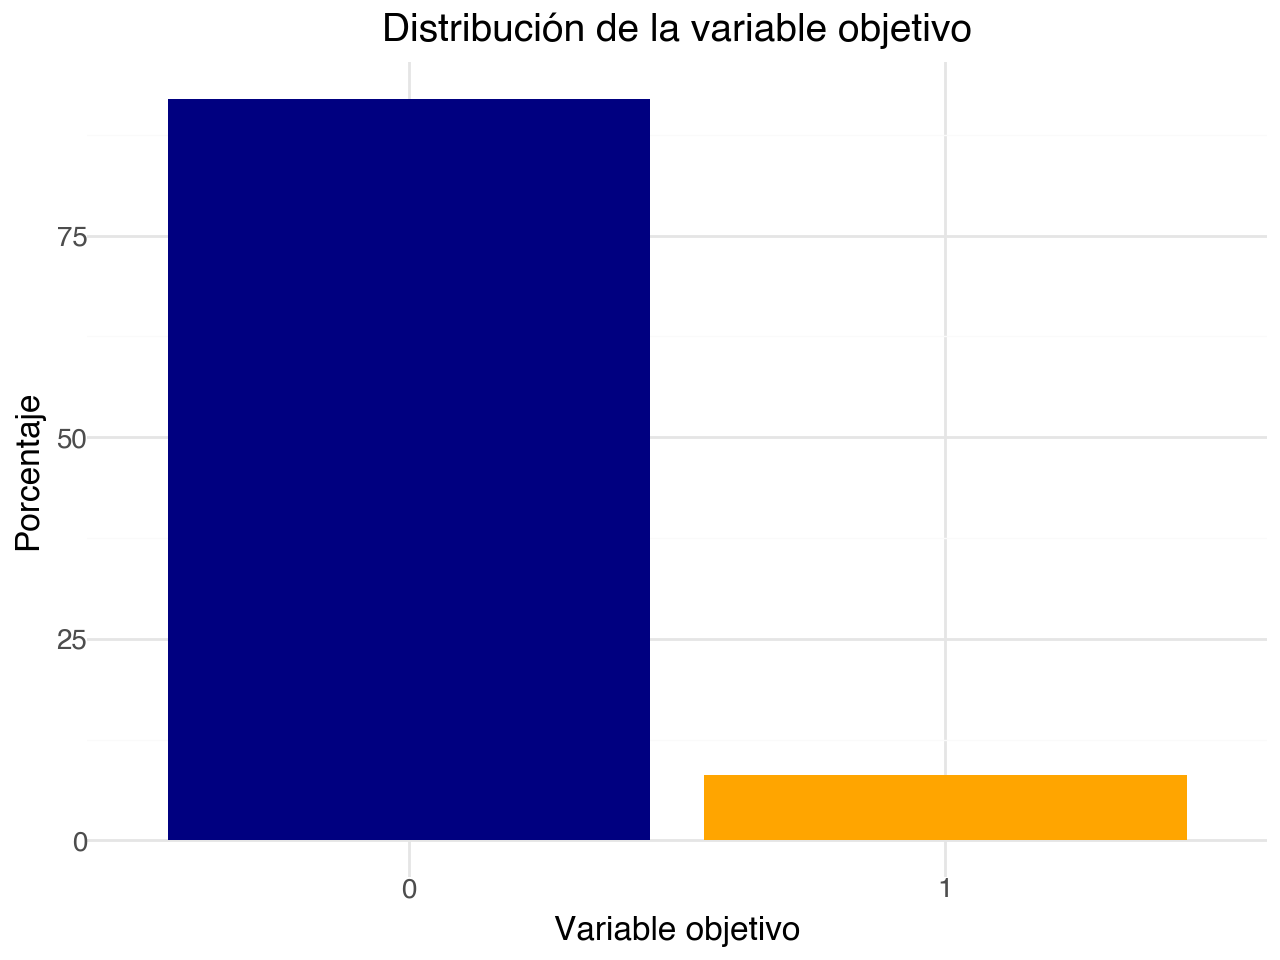

In [14]:
# Visualizar el conteo de los valores de la variable objetivo
# ==============================================================================
pd_plot_target_pc['TARGET'] = pd_plot_target_pc['TARGET'].astype(str)

(ggplot(pd_plot_target_pc, aes(x='TARGET', y='percent', fill='TARGET')) 
    + geom_bar(stat='identity', show_legend=False)  
    + labs(
        x='Variable objetivo', 
        y='Porcentaje', 
        title='Distribución de la variable objetivo'
    ) 
    + scale_fill_manual(values=['navy', 'orange'])  
    + theme_minimal()  
    + theme(
        plot_title=element_text(size=14, weight='bold', ha='center'),
        axis_title=element_text(size=12),
        axis_text=element_text(size=10),
    )
)

Como hemos comentado en notebook anterior, se puede observar que el muestreo está desbalanceado, ya que la mayoría de los clientes no tienen dificultades para pagar el préstamo.

El 20% de los datos se asignan al conjunto de prueba y el 80% al conjunto de entrenamiento para entrenar el modelo con la mayoría de los datos y evaluar su desempeño con una muestra representativa y no utilizada en el entrenamiento.

In [14]:
from sklearn.model_selection import train_test_split
X_pd_loan, X_pd_loan_test, y_pd_loan, y_pd_loan_test = train_test_split(pd_loan.drop('TARGET',axis=1), 
                                                                     pd_loan['TARGET'], 
                                                                     stratify=pd_loan['TARGET'], 
                                                                     test_size=0.2)
pd_loan_train = pd.concat([X_pd_loan, y_pd_loan],axis=1)
pd_loan_test = pd.concat([X_pd_loan_test, y_pd_loan_test],axis=1)

In [15]:
print('== Train\n', pd_loan_train['TARGET'].value_counts(normalize=True))
print('== Test\n', pd_loan_test['TARGET'].value_counts(normalize=True))

== Train
 TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64
== Test
 TARGET
0    0.919272
1    0.080728
Name: proportion, dtype: float64



La salida muestra que tanto en el conjunto de entrenamiento como en el de prueba, las proporciones de ambas clases son prácticamente idénticas, lo que nos confirma que la separación estratificada ha mantenido el balance de las clases en ambos conjuntos.

# Visualización descriptiva de los datos:


Este análisis muestra la cantidad de valores nulos por filas y por columnas en el conjunto de entrenamiento, ayudando a identificar qué variables o registros contienen datos faltantes.

In [16]:
# Encontrar nulos por columnas
# ==============================================================================
pd_series_null_columns = pd_loan_train.isnull().sum().sort_values(ascending=False)

# Encontrar nulos por filas
# ==============================================================================
pd_series_null_rows = pd_loan_train.isnull().sum(axis=1).sort_values(ascending=False)

# Dimensiones
# ==============================================================================
print(pd_series_null_columns.shape, pd_series_null_rows.shape)

pd_null_columnas = pd.DataFrame(pd_series_null_columns, columns=['nulos_columnas'])     
pd_null_filas = pd.DataFrame(pd_series_null_rows, columns=['nulos_filas'])  
pd_null_filas['target'] = pd_loan['TARGET'].copy()
pd_null_columnas['porcentaje_columnas'] = pd_null_columnas['nulos_columnas']/pd_loan_train.shape[0]
pd_null_filas['porcentaje_filas']= pd_null_filas['nulos_filas']/pd_loan_train.shape[1]

(121,) (246008,)


In [17]:
pd_null_columnas

nulos_columnas  porcentaje_columnas
COMMONAREA_MODE                       171765             0.698209
COMMONAREA_MEDI                       171765             0.698209
COMMONAREA_AVG                        171765             0.698209
NONLIVINGAPARTMENTS_MEDI              170752             0.694091
NONLIVINGAPARTMENTS_MODE              170752             0.694091
NONLIVINGAPARTMENTS_AVG               170752             0.694091
LIVINGAPARTMENTS_AVG                  168103             0.683323
LIVINGAPARTMENTS_MEDI                 168103             0.683323
LIVINGAPARTMENTS_MODE                 168103             0.683323
FONDKAPREMONT_MODE                    168099             0.683307
FLOORSMIN_MODE                        166833             0.678161
FLOORSMIN_MEDI                        166833             0.678161
FLOORSMIN_AVG                         166833             0.678161
YEARS_BUILD_MEDI                      163466             0.664474
YEARS_BUILD_AVG                       163466             0.664474
YEARS_BUILD_MODE                      163466             0.664474
OWN_CAR_AGE                           162379             0.660056
LANDAREA_MEDI                         145984             0.593412
LANDAREA_AVG                          145984             0.593412
LANDAREA_MODE                         145984             0.593412
BASEMENTAREA_MEDI                     143904             0.584957
BASEMENTAREA_MODE                     143904             0.584957
BASEMENTAREA_AVG                      143904             0.584957
EXT_SOURCE_1                          138763             0.564059
NONLIVINGAREA_AVG                     135626             0.551307
NONLIVINGAREA_MEDI                    135626             0.551307
NONLIVINGAREA_MODE                    135626             0.551307
ELEVATORS_AVG                         130969             0.532377
ELEVATORS_MEDI                        130969             0.532377
ELEVATORS_MODE                        130969             0.532377
WALLSMATERIAL_MODE                    124985             0.508053
APARTMENTS_AVG                        124774             0.507195
APARTMENTS_MODE                       124774             0.507195
APARTMENTS_MEDI                       124774             0.507195
ENTRANCES_MODE                        123764             0.503089
ENTRANCES_AVG                         123764             0.503089
ENTRANCES_MEDI                        123764             0.503089
LIVINGAREA_MODE                       123428             0.501724
LIVINGAREA_AVG                        123428             0.501724
LIVINGAREA_MEDI                       123428             0.501724
HOUSETYPE_MODE                        123357             0.501435
FLOORSMAX_MEDI                        122356             0.497366
FLOORSMAX_AVG                         122356             0.497366
FLOORSMAX_MODE                        122356             0.497366
YEARS_BEGINEXPLUATATION_MEDI          119930             0.487504
YEARS_BEGINEXPLUATATION_MODE          119930             0.487504
YEARS_BEGINEXPLUATATION_AVG           119930             0.487504
TOTALAREA_MODE                        118675             0.482403
EMERGENCYSTATE_MODE                   116515             0.473623
OCCUPATION_TYPE                        77135             0.313547
EXT_SOURCE_3                           48826             0.198473
AMT_REQ_CREDIT_BUREAU_MON              33199             0.134951
AMT_REQ_CREDIT_BUREAU_HOUR             33199             0.134951
AMT_REQ_CREDIT_BUREAU_YEAR             33199             0.134951
AMT_REQ_CREDIT_BUREAU_QRT              33199             0.134951
AMT_REQ_CREDIT_BUREAU_DAY              33199             0.134951
AMT_REQ_CREDIT_BUREAU_WEEK             33199             0.134951
NAME_TYPE_SUITE                         1053             0.004280
OBS_30_CNT_SOCIAL_CIRCLE                 832             0.003382
DEF_30_CNT_SOCIAL_CIRCLE                 832             0.003382
OBS_

In [18]:
pd_null_filas.head()

nulos_filas target  porcentaje_filas
SK_ID_CURR                                      
412312               61      0          0.504132
412671               61      0          0.504132
274127               61      0          0.504132
255145               61      0          0.504132
180861               61      0          0.504132

No se ha eliminado ninguna columna en este análisis, ya que no se ha identificado un porcentaje de valores nulos lo suficientemente alto como para justificarlo. Aunque en general es importante eliminar columnas con un exceso de nulos para evitar pérdida de información importante, en este caso todas las columnas se han conservado, considerando que incluso aquellas con valores faltantes podrían seguir siendo relevantes.

A continuación, visualizamos la distribución de las demás variables en el conjunto de datos, tanto de manera general como en función de la variable objetivo. Esto nos permitirá entender mejor cómo se distribuyen las variables y cómo podrían estar relacionadas con la presencia de dificultades de pago en los clientes (1: dificultades de pago, 0: sin dificultades de pago).

Para facilitar la interpretación y comprensión de los gráficos, primero se graficarán las variables continuas y, a continuación, las variables categóricas.

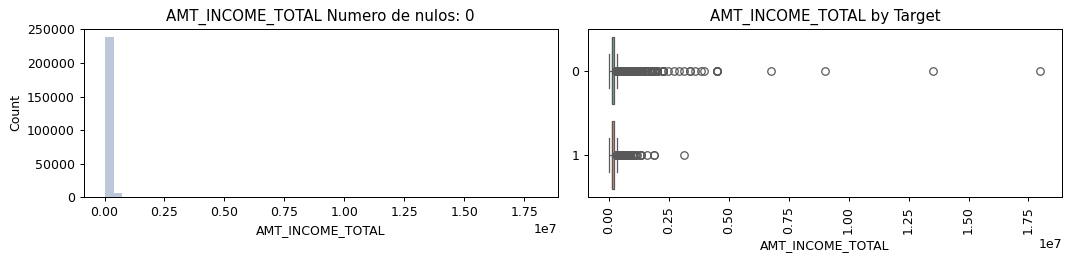

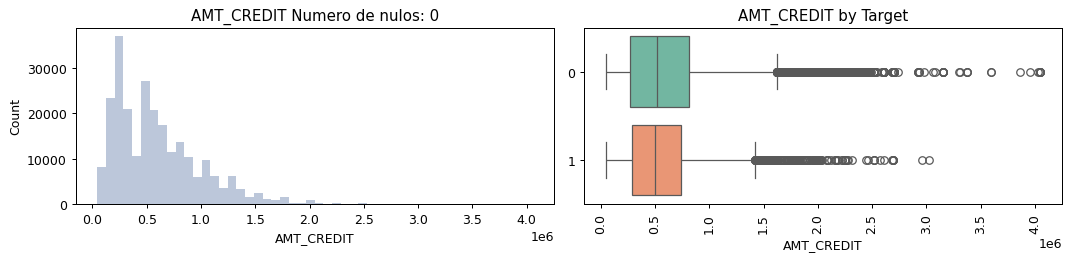

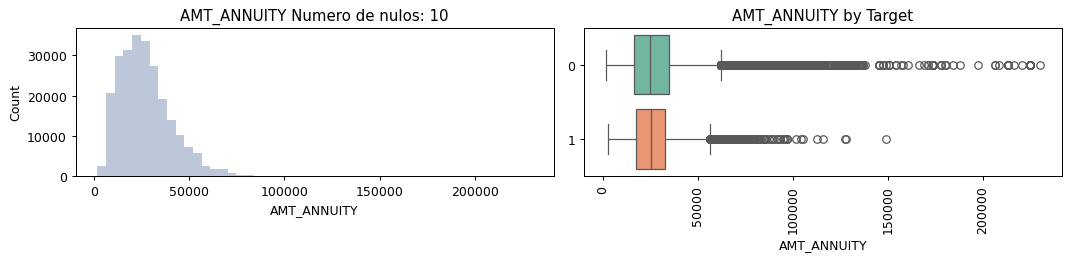

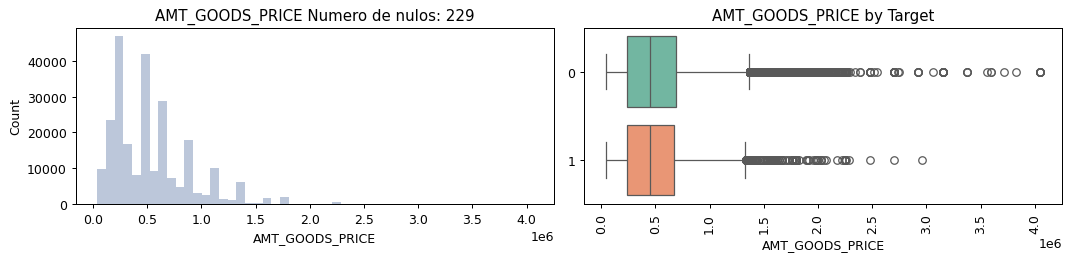

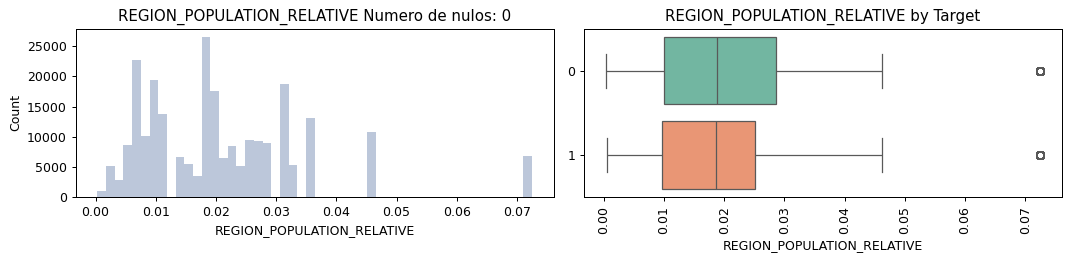

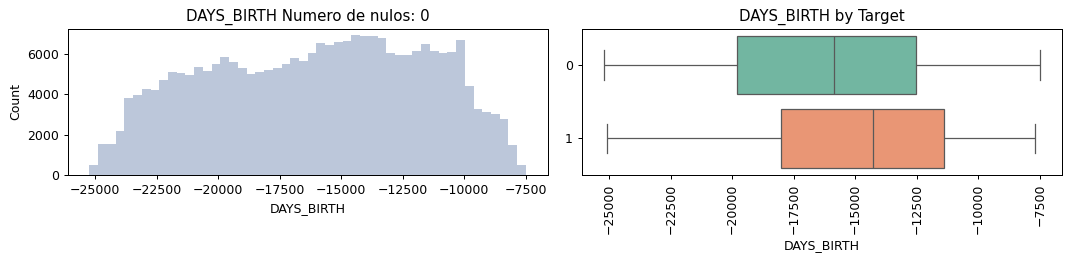

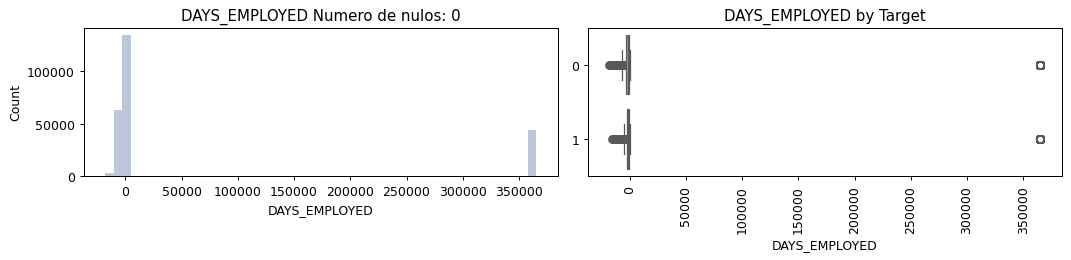

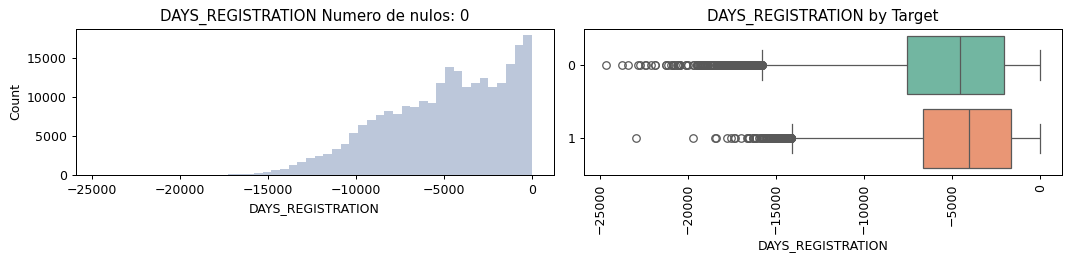

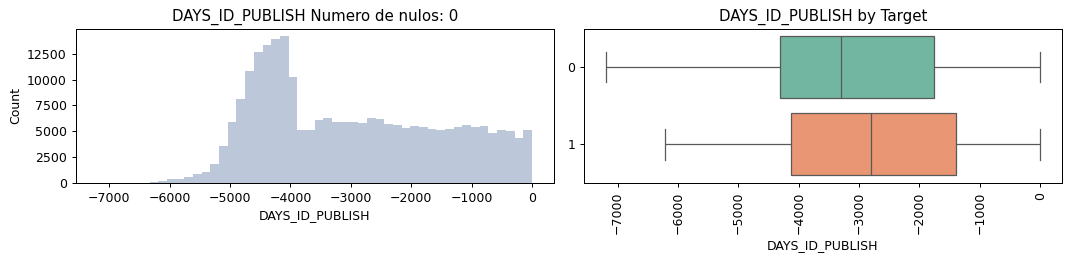

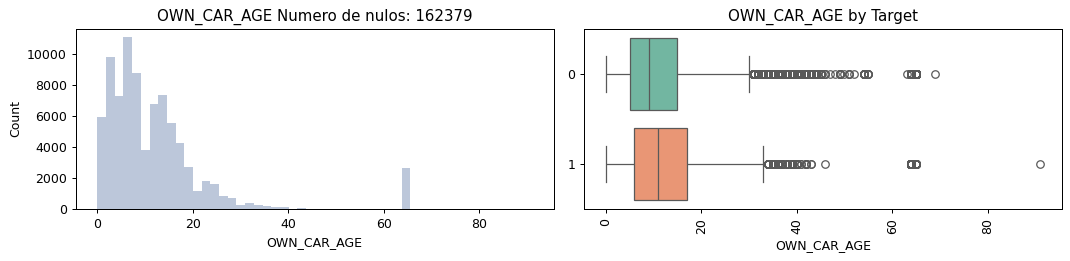

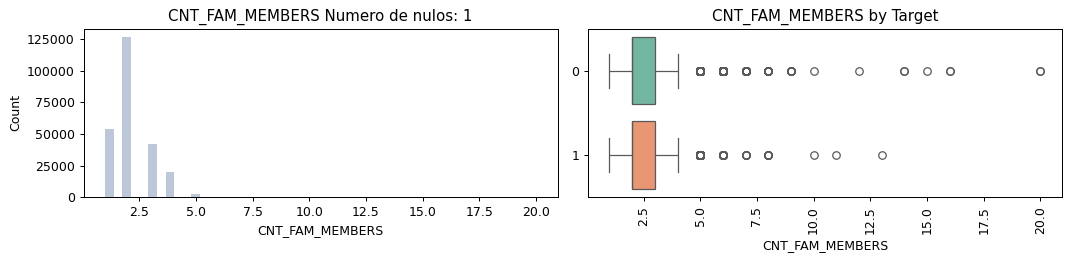

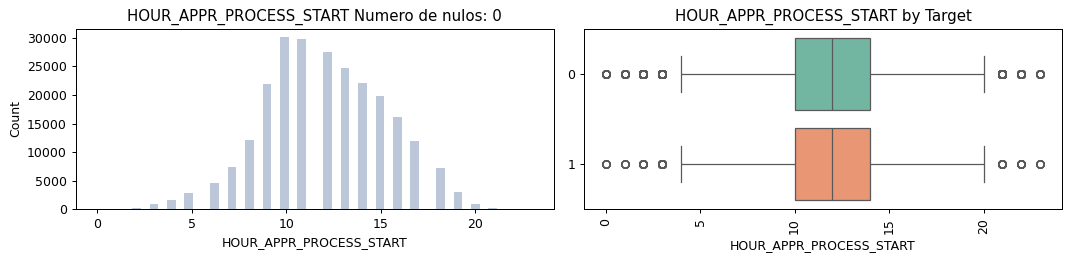

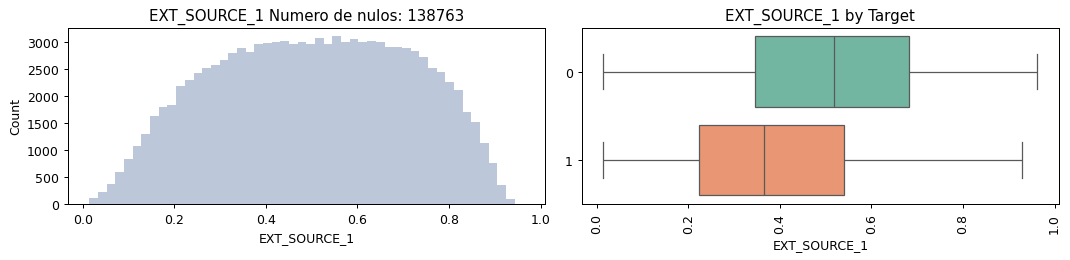

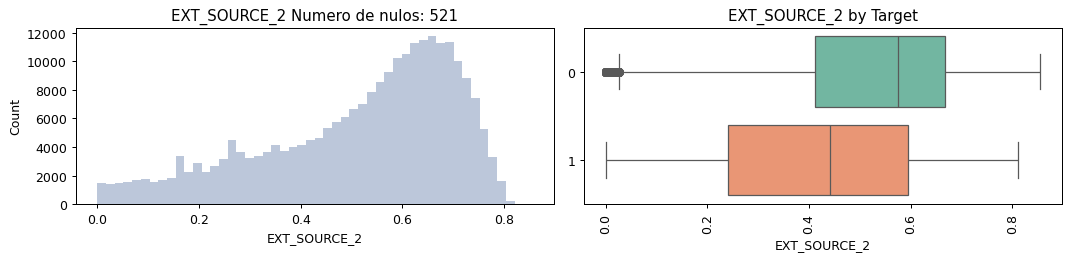

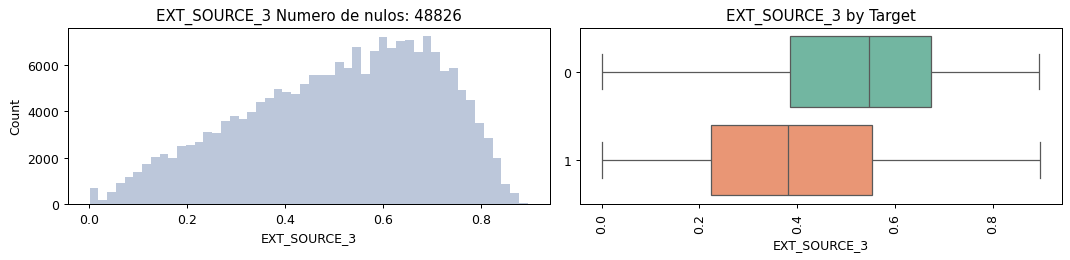

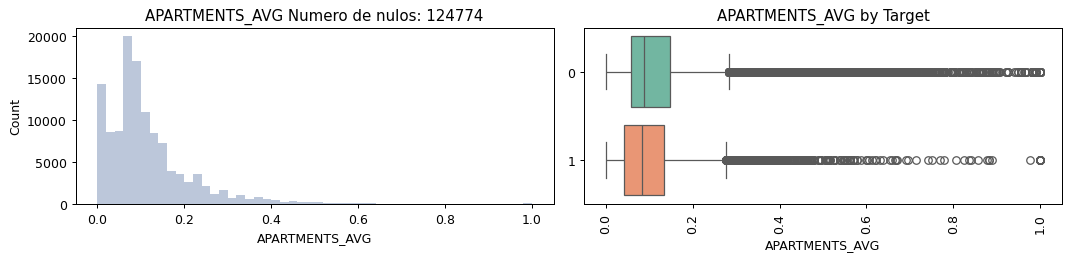

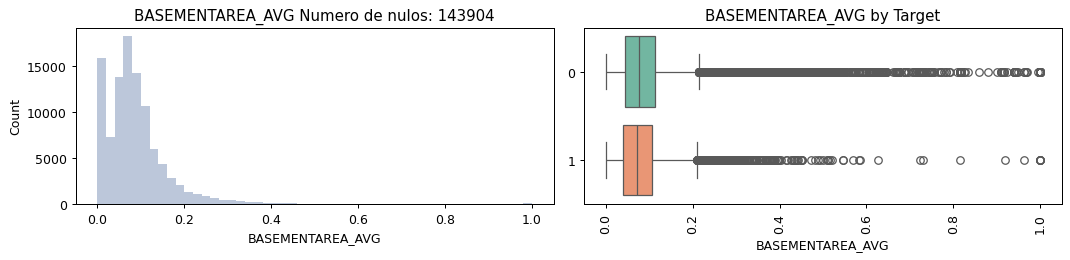

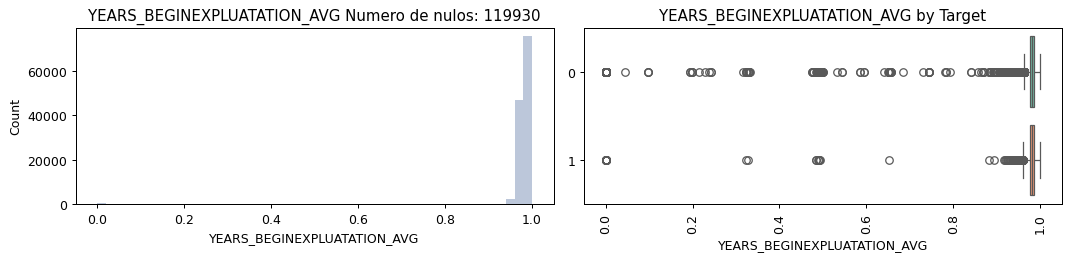

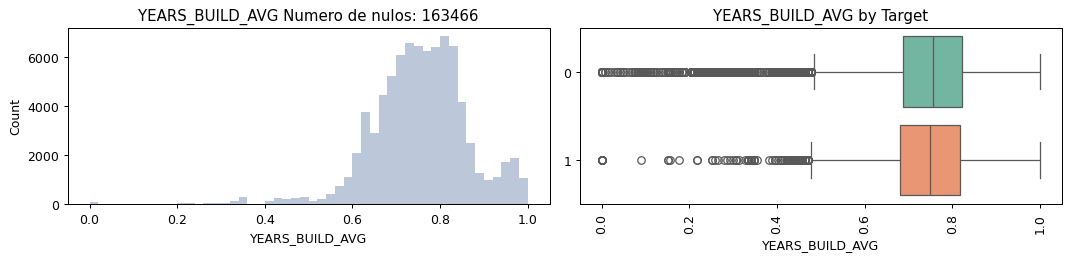

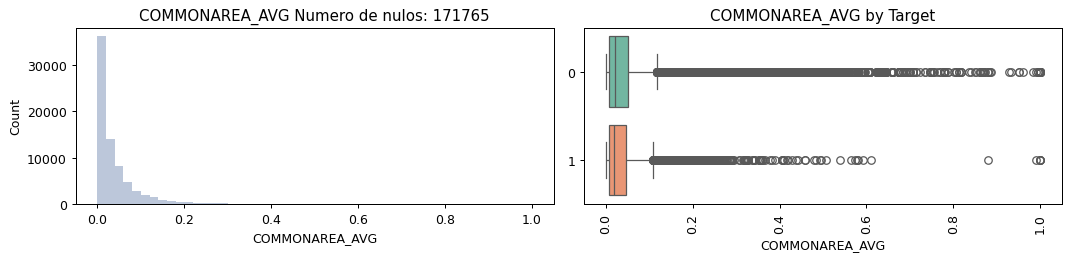

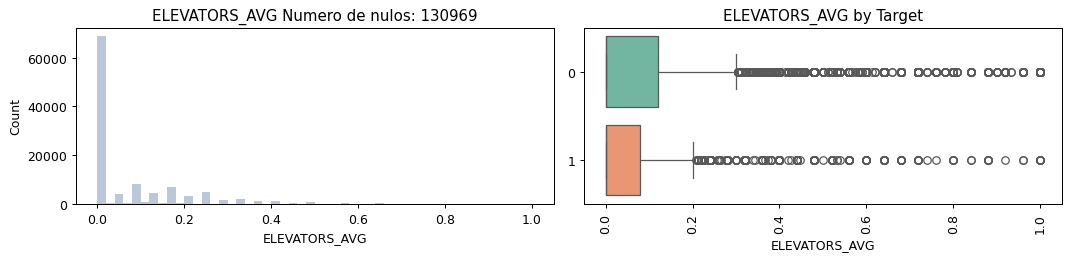

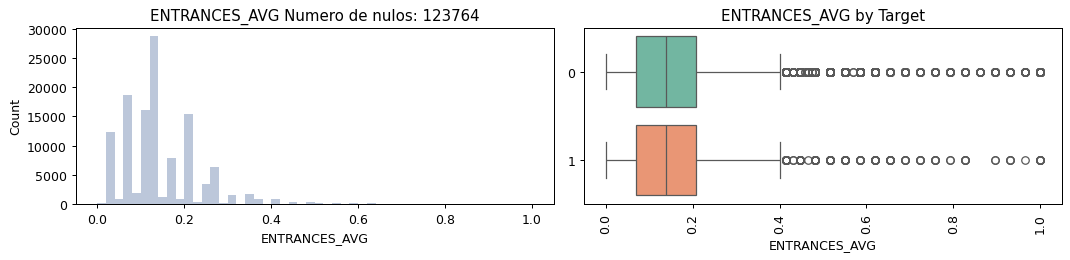

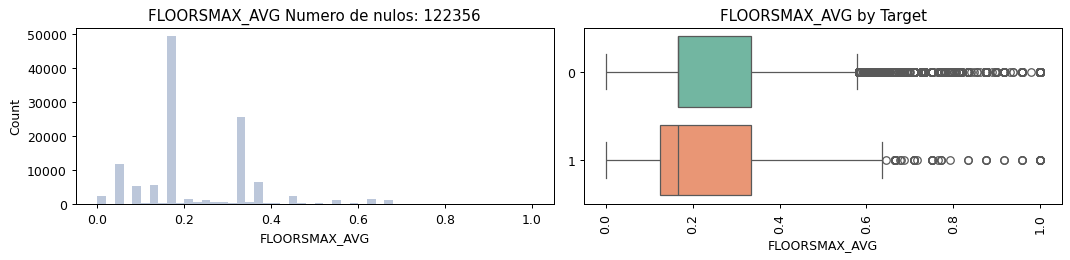

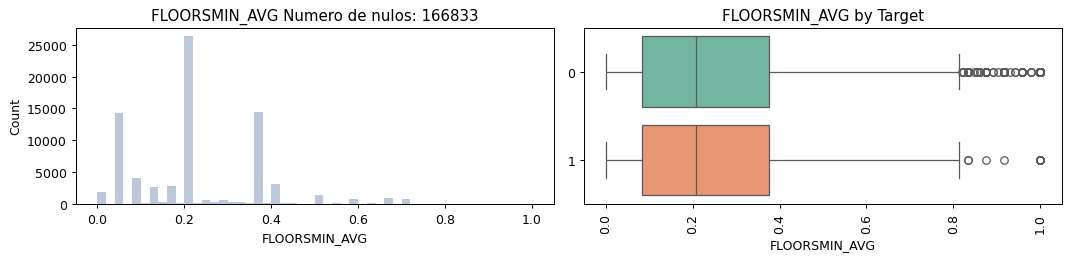

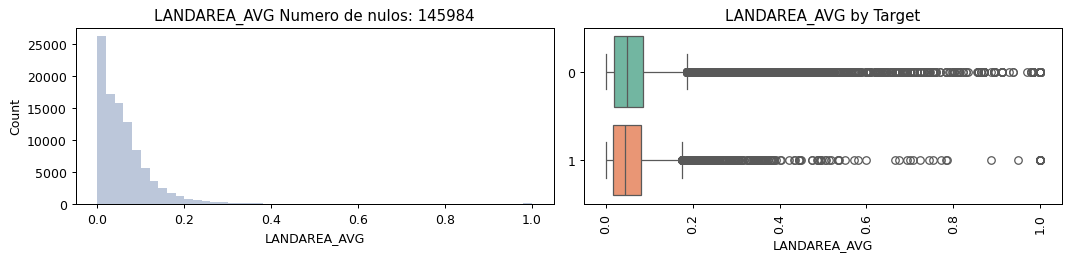

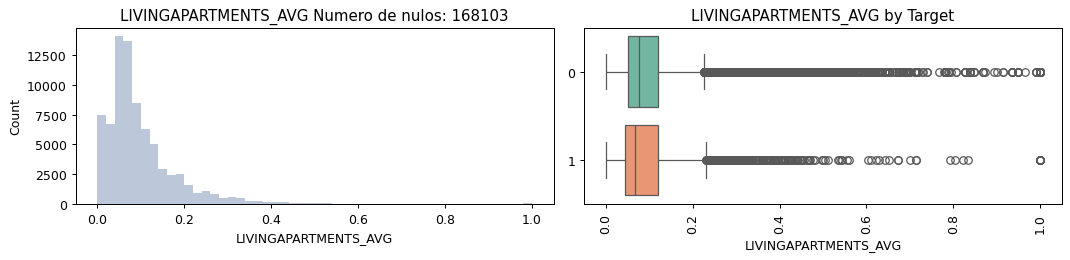

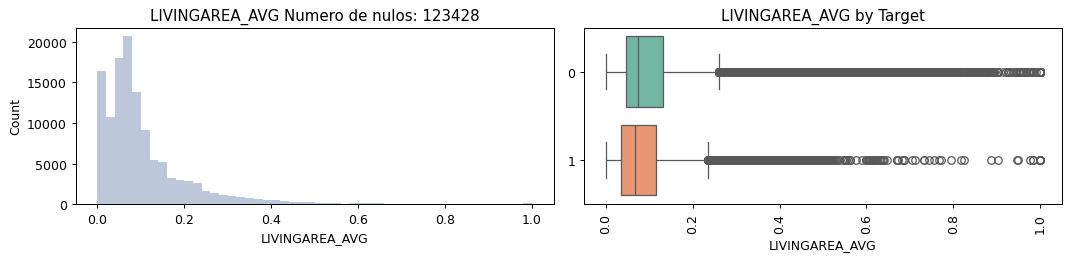

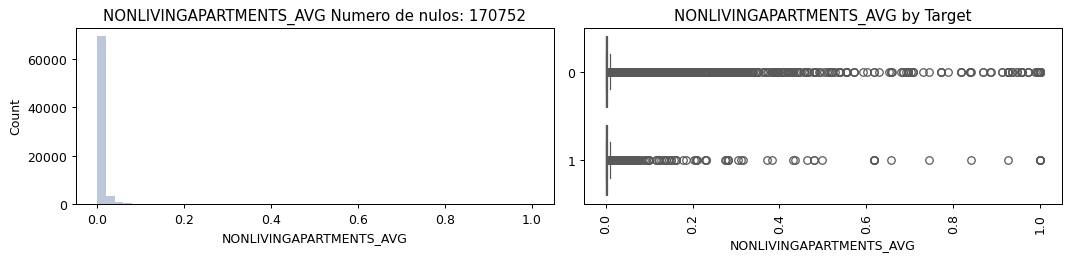

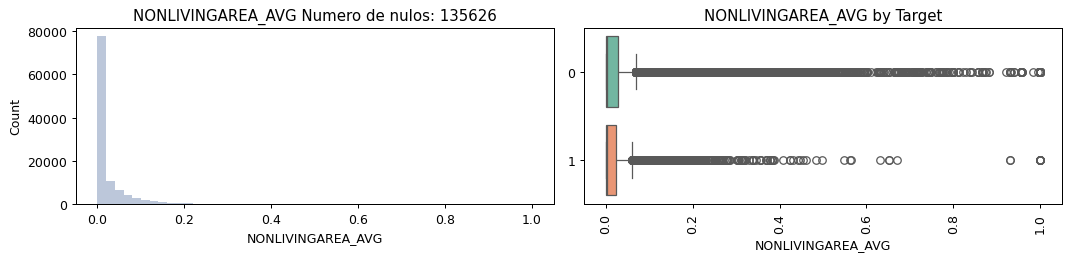

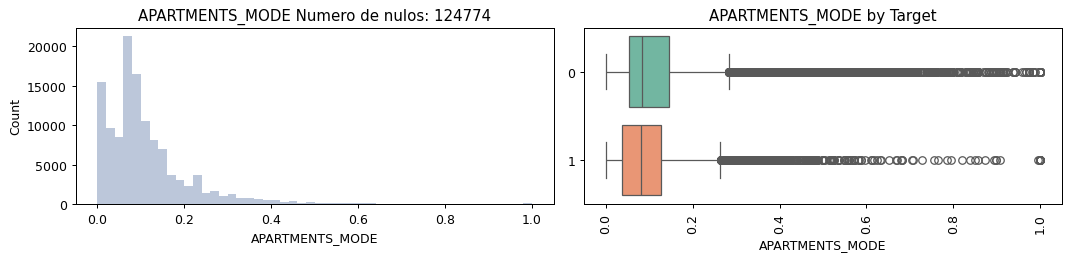

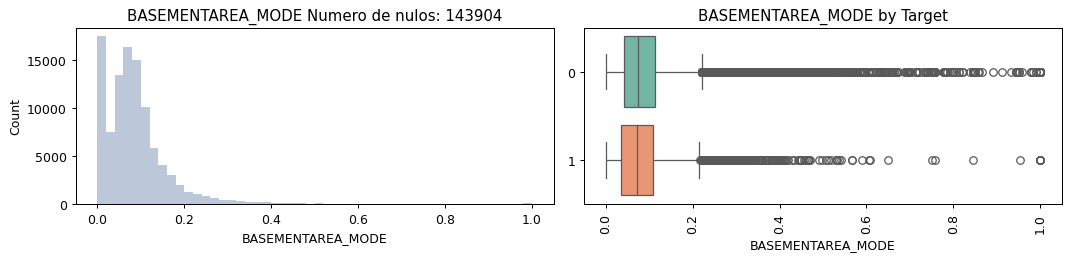

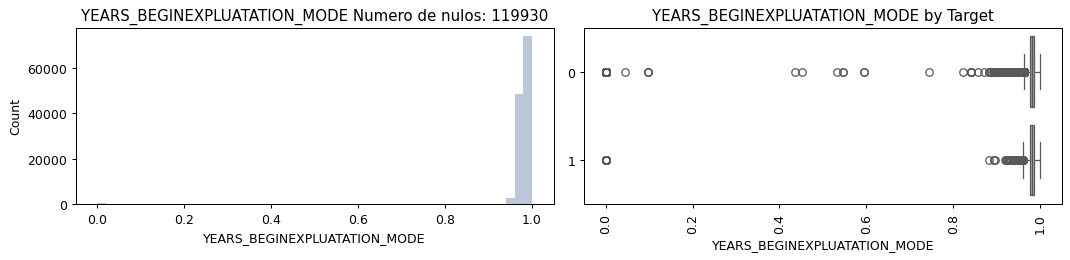

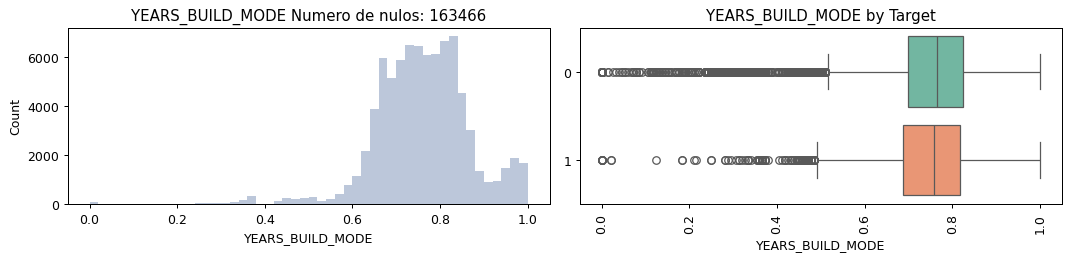

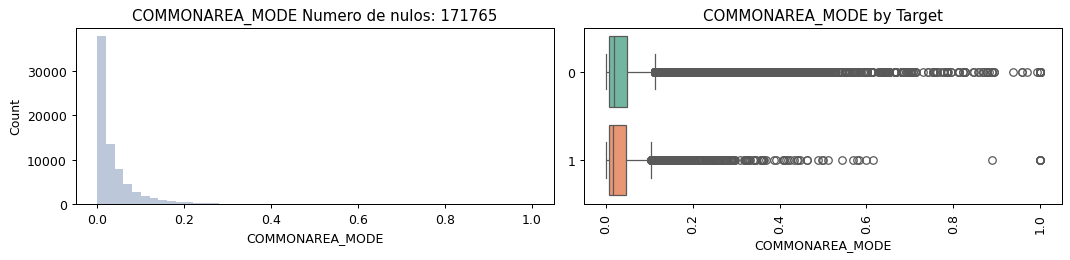

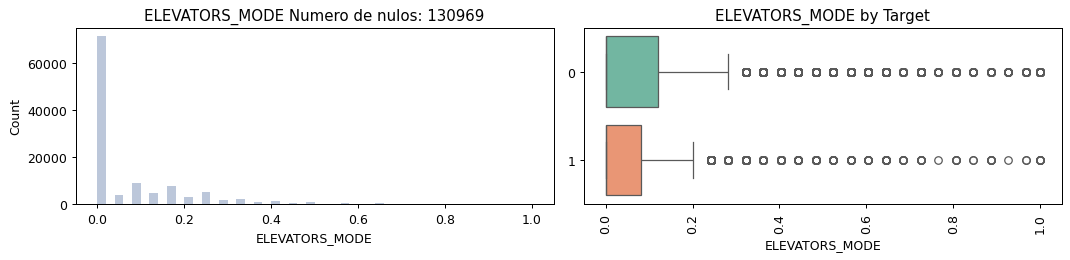

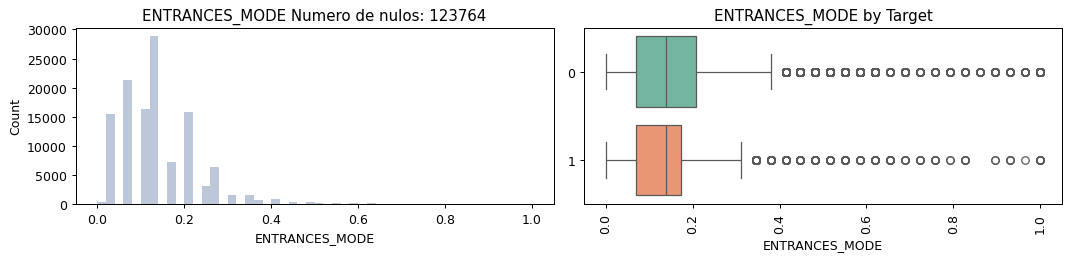

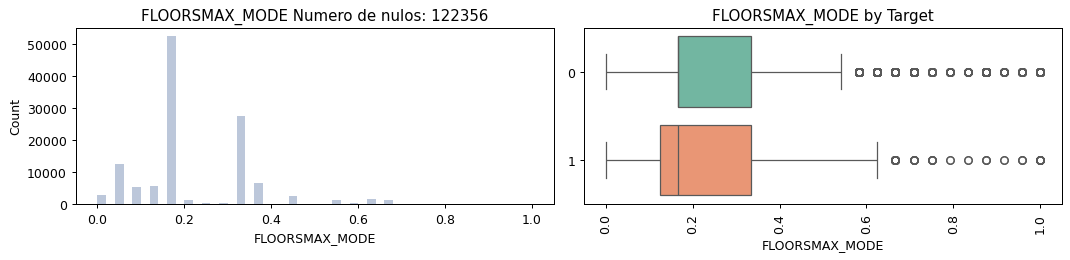

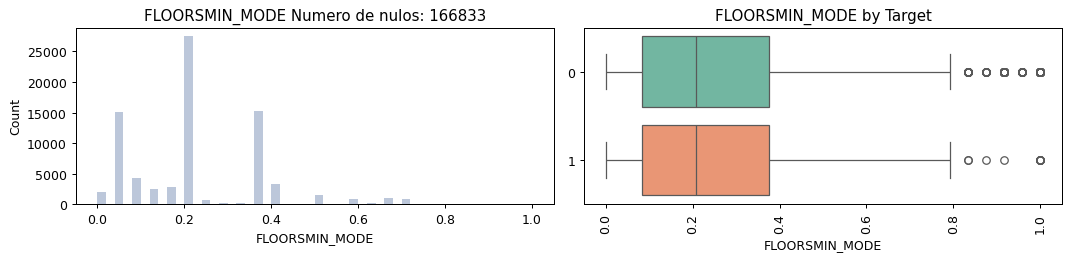

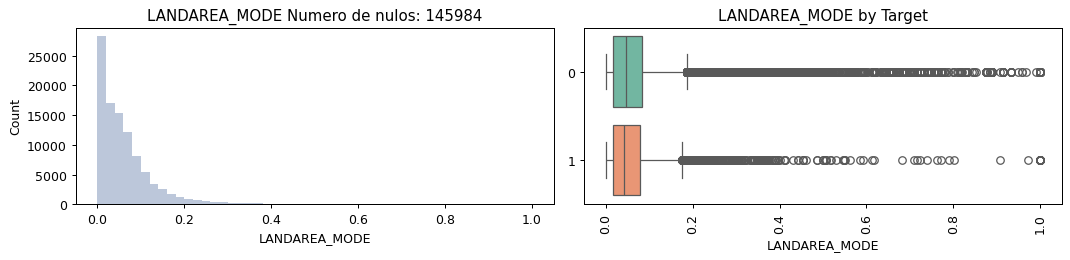

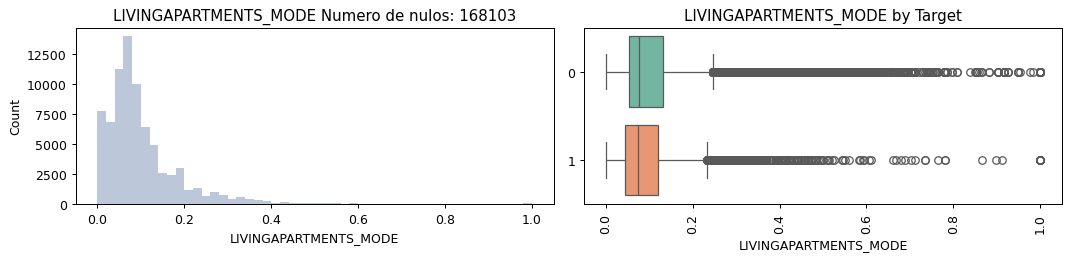

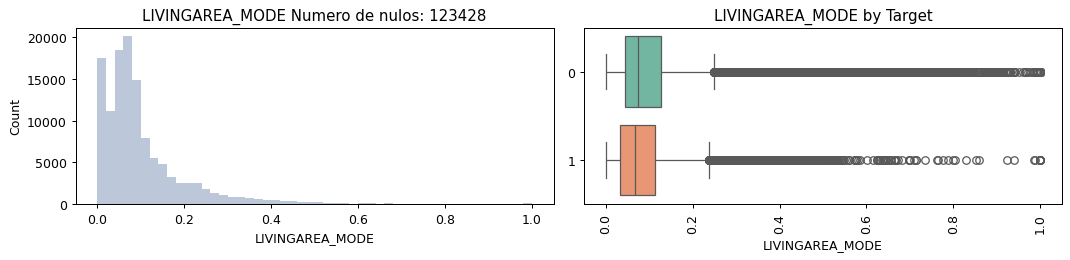

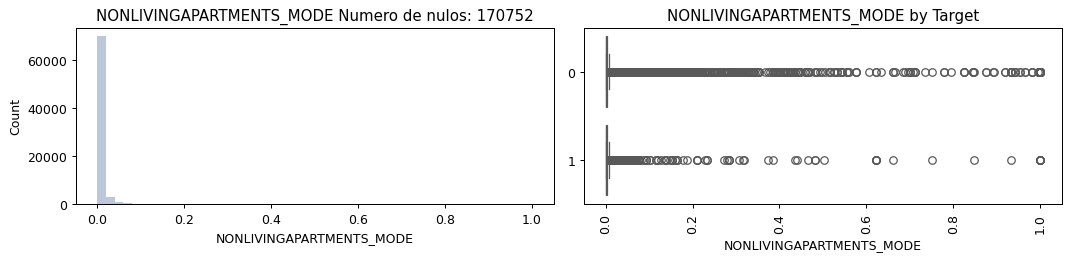

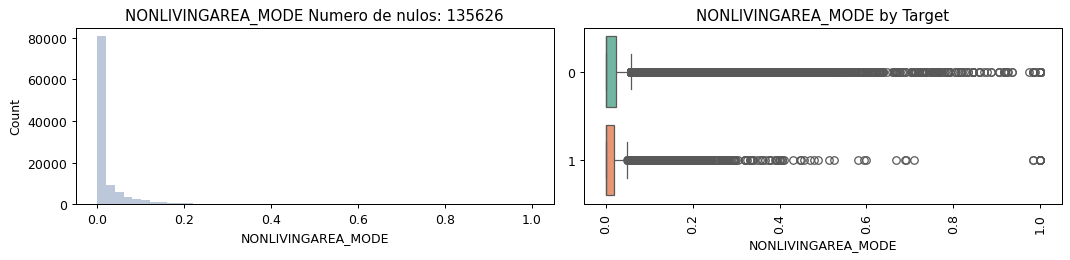

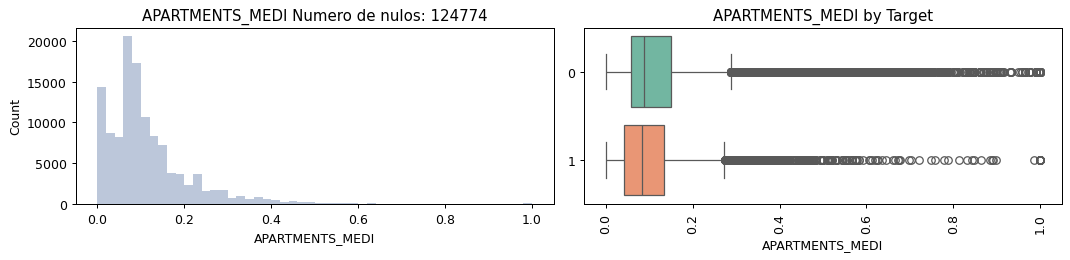

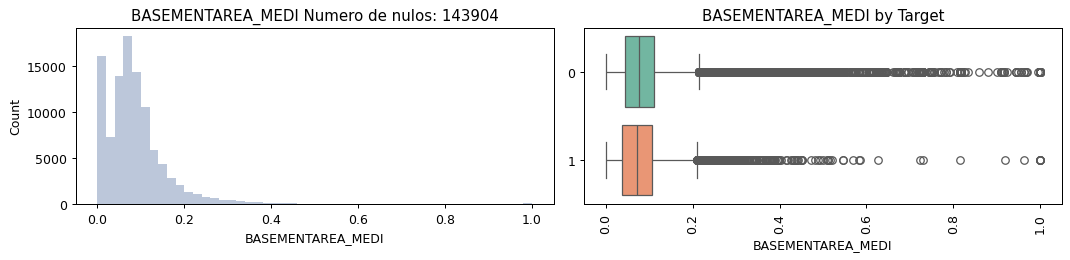

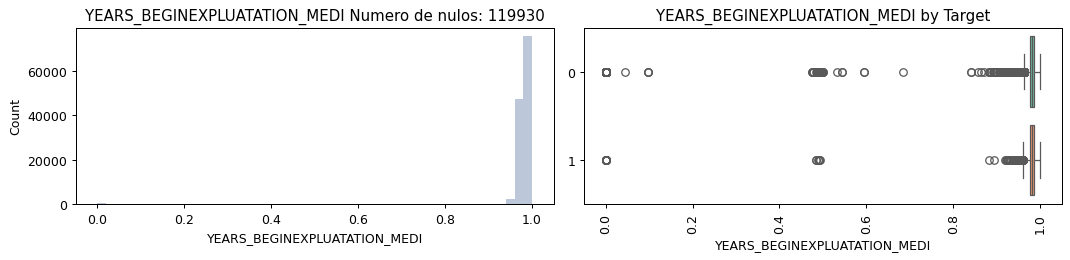

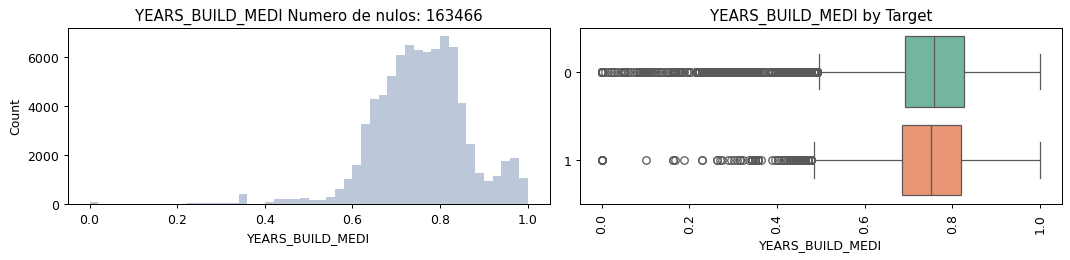

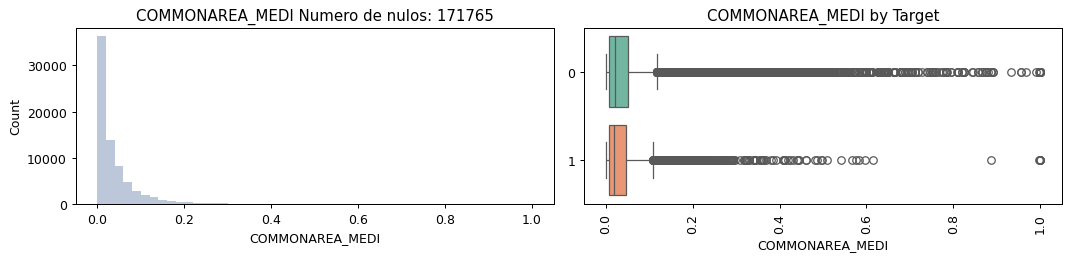

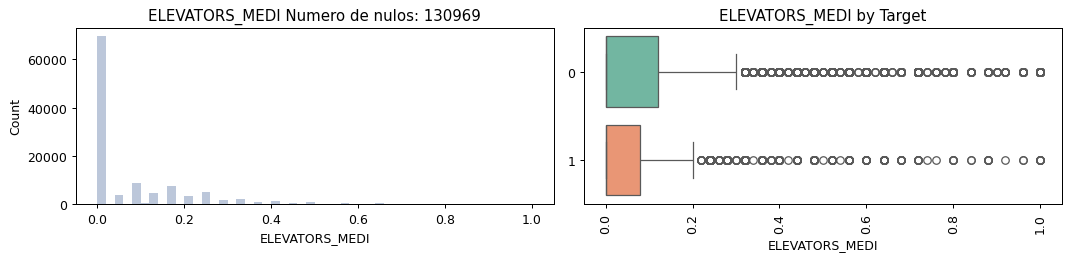

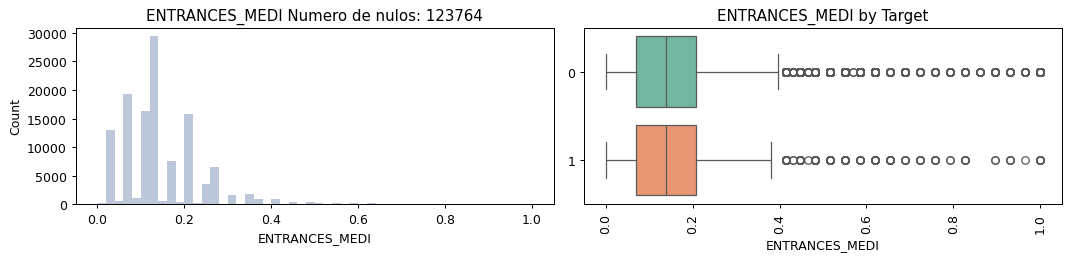

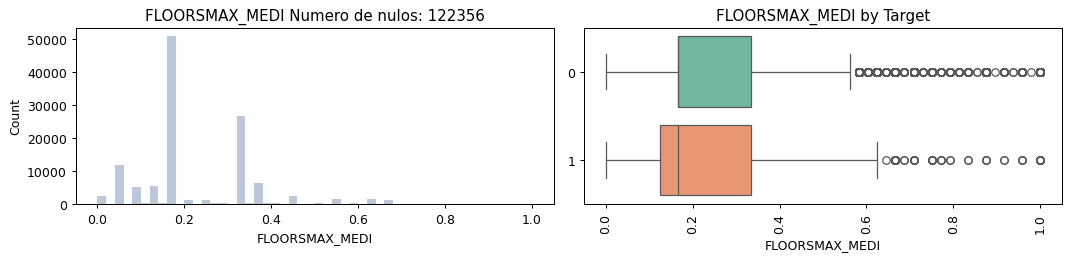

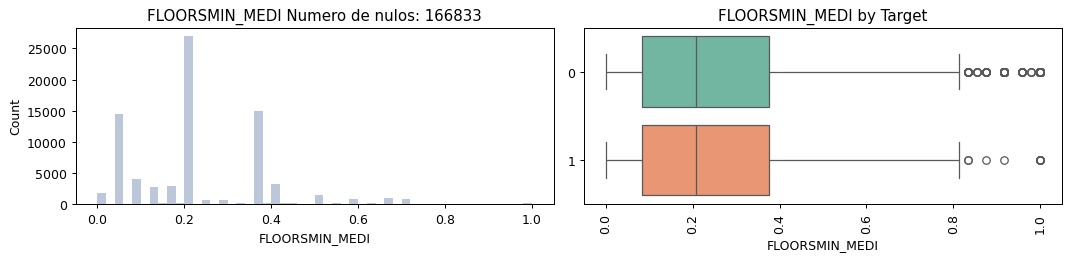

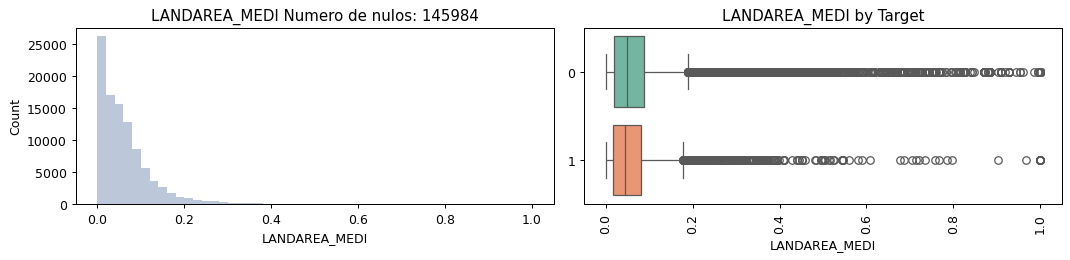

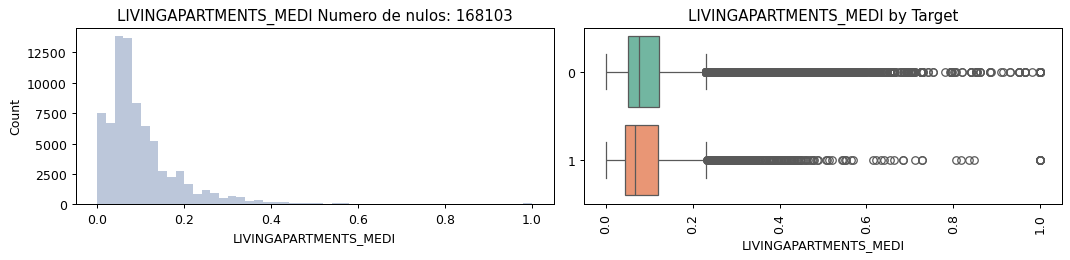

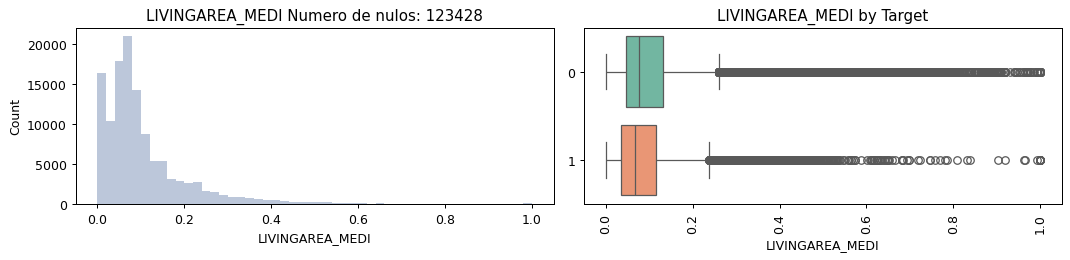

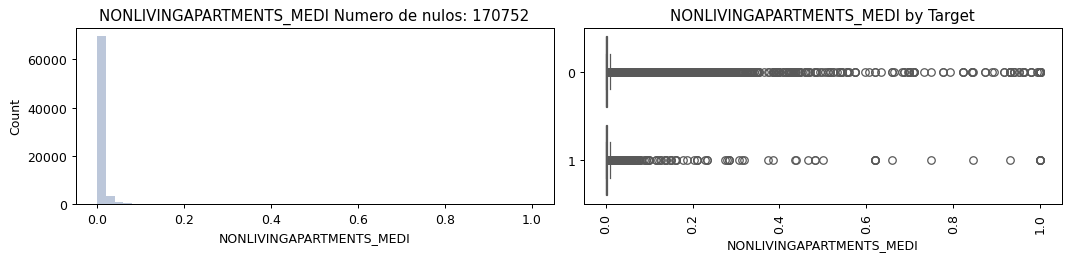

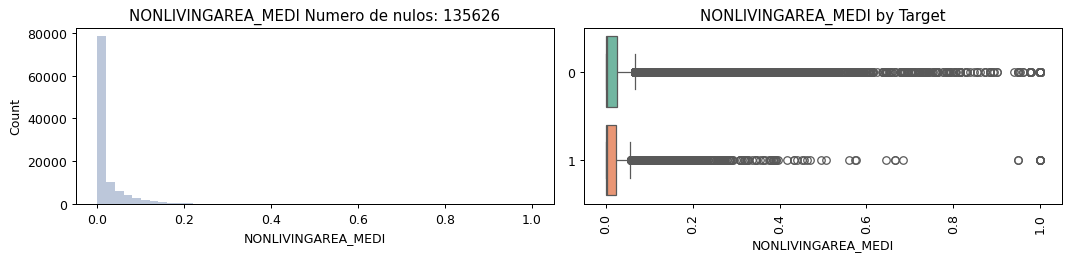

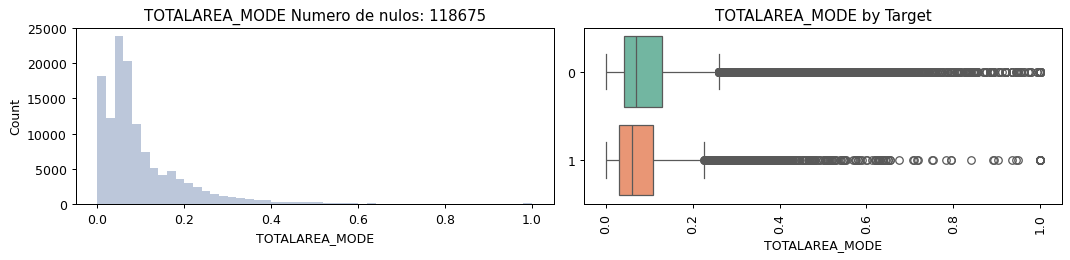

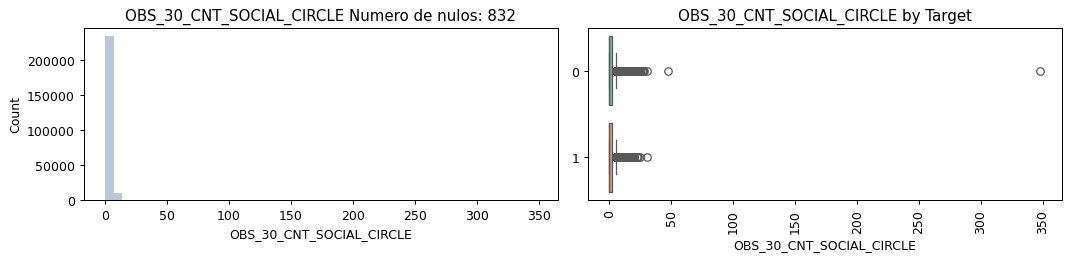

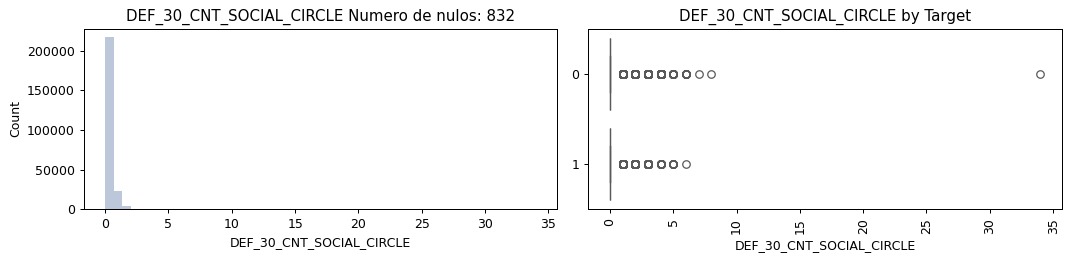

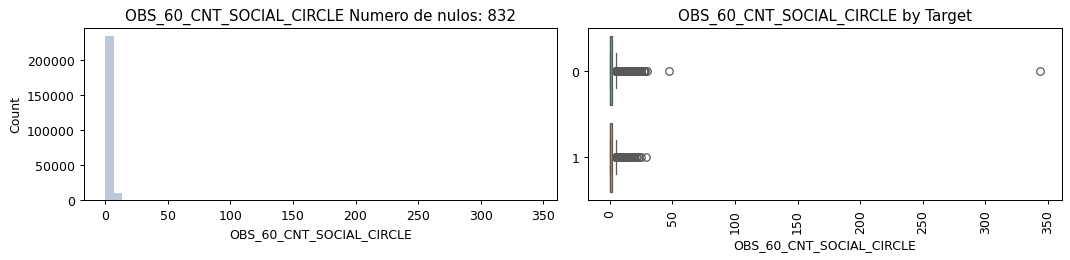

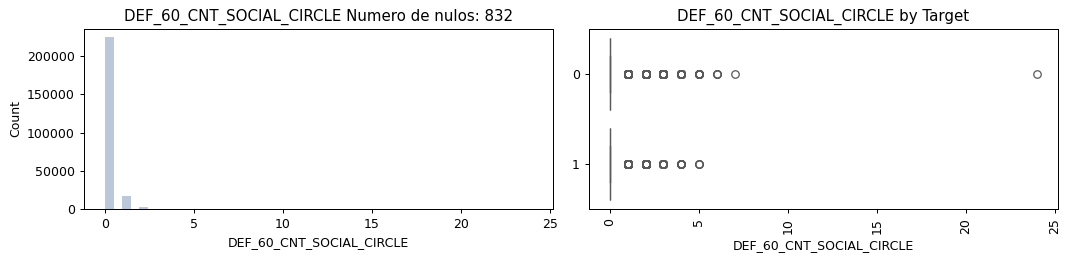

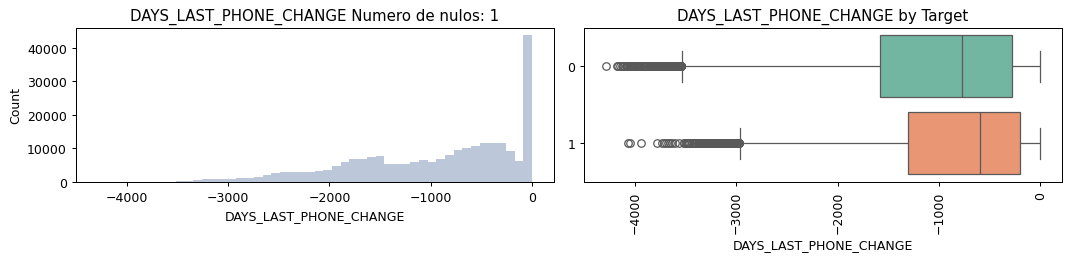

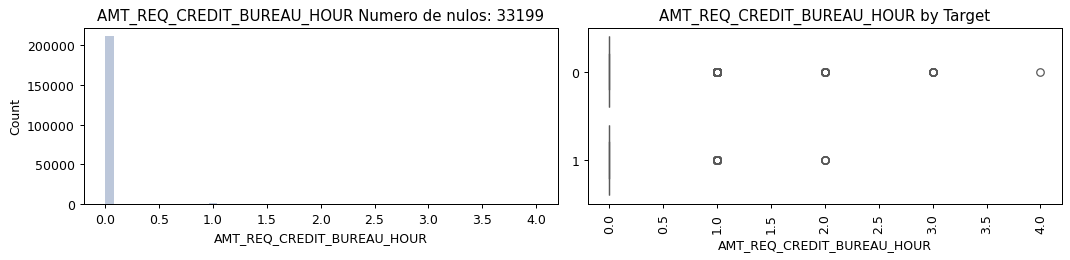

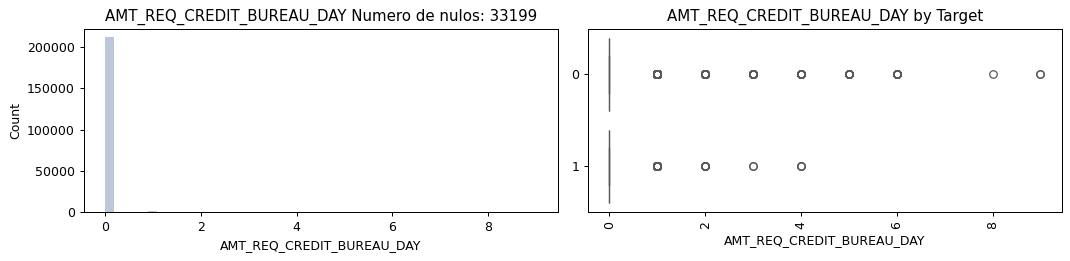

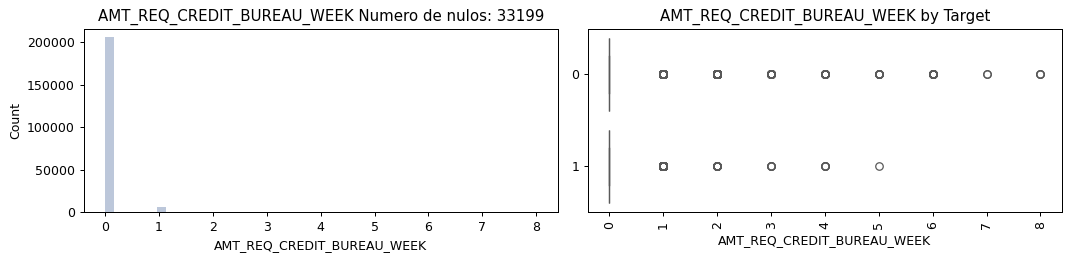

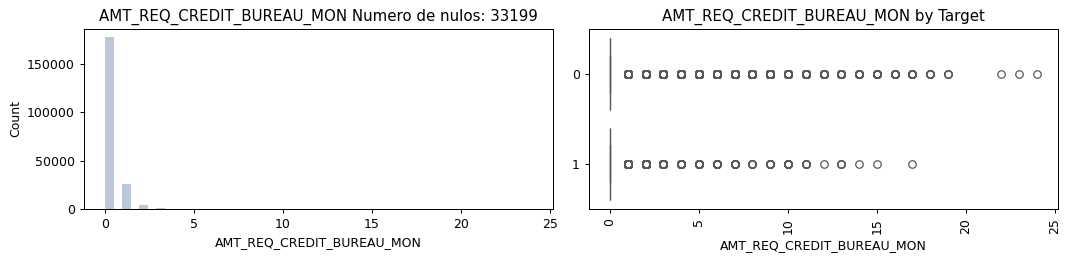

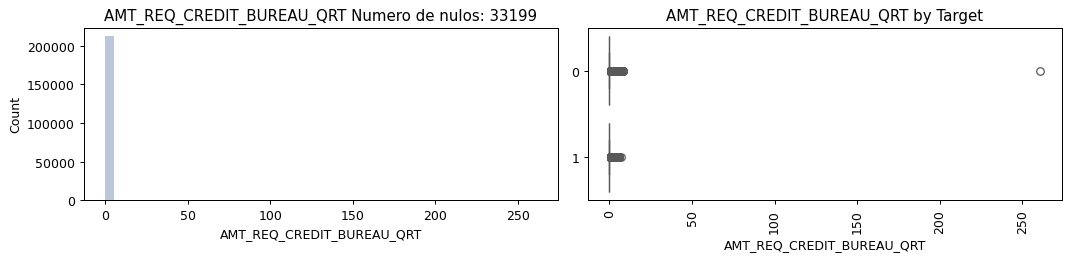

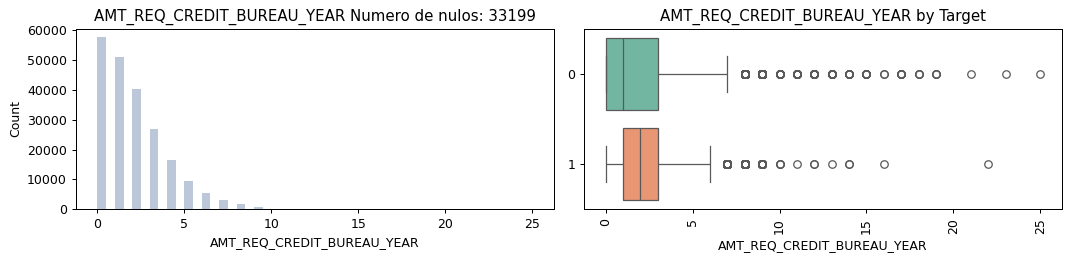

In [20]:
warnings.filterwarnings('ignore')
for i in list(pd_loan_train.columns):
    if (pd_loan_train[i].dtype==float) & (i!='TARGET'):

        funciones.plot_feature(pd_loan_train, col_name=i, isContinuous=True)

Empiezo analizando las variables continuas. Para ello, me fijo en la forma de la distribución en el histograma, ya que esto me puede indicar si los datos siguen una distribución normal, están sesgados o tienen múltiples picos. También observo el boxplot para identificar valores atípicos y entender la dispersión de los datos a través del rango intercuartílico. Además, examino cómo se relaciona la variable continua con la variable objetivo, buscando diferencias claras entre las clases. Por último, reviso la cantidad de valores nulos, ya que pueden influir en la calidad del análisis.

La primera variable que analizo es la población relativa por región. El boxplot muestra una ligera diferencia en función de la variable objetivo, con un rango intercuartílico más amplio en las regiones sin dificultades de pago. Esto podría sugerir que las regiones con mayor población tienen menos dificultades para cumplir con los pagos.

La siguiente variable es la edad en días de vida. El boxplot revela que los clientes más jóvenes tienen más dificultades para pagar, ya que la mediana de este grupo es más baja en comparación con aquellos que no presentan dificultades de pago. 

También es interesante observar la relación con el coche de los clientes, los clientes que poseen coches de mayor antigüedad parecen tener más dificultades para pagar

Es útil analizar las variables externas (puntuación normalizada de una fuente de datos externa), cuyos histogramas siguen una distribución normal sesgada, con un pico a la derecha. Los boxplots también muestran medianas diferentes según la variable objetivo. Sin embargo, debido a la falta de información sobre la definición exacta de estas variables, no es posible sacar conclusiones definitivas.

Otra variable interesante a comentar es `FLOORSMAX_` (información normalizada sobre el edificio donde vive el cliente). Aunque presenta una gran cantidad de valores nulos y outliers, lo que podría afectar la validez de las conclusiones, los valores más bajos parecen estar asociados con mayores dificultades de pago.

También quiero destacar el impacto del tiempo transcurrido desde que el cliente cambió su número de teléfono antes de solicitar la aplicación. Se observa que aquellos clientes que realizaron este cambio más recientemente tienden a presentar mayores dificultades para cumplir con sus pagos.

Por último, es importante destacar que, debido a la distribución de los datos y la forma en que se presentan, es complicado sacar conclusiones claras de algunas variables. Entre ellas se encuentran `YEARS_BEGINEXPLUATATION_AVG` y `NONLIVINGAPARMENTS_AVG`, entre otras.

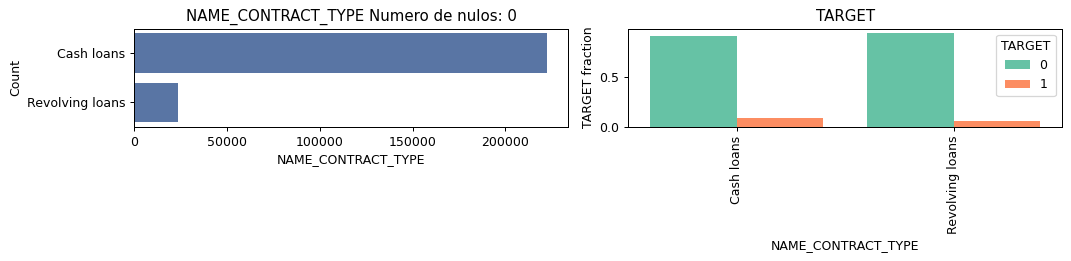

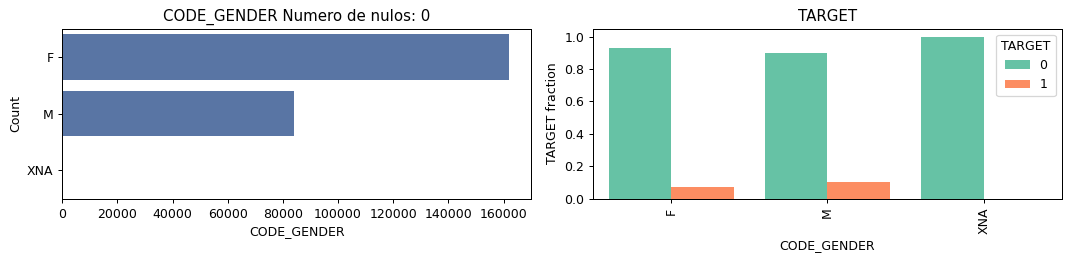

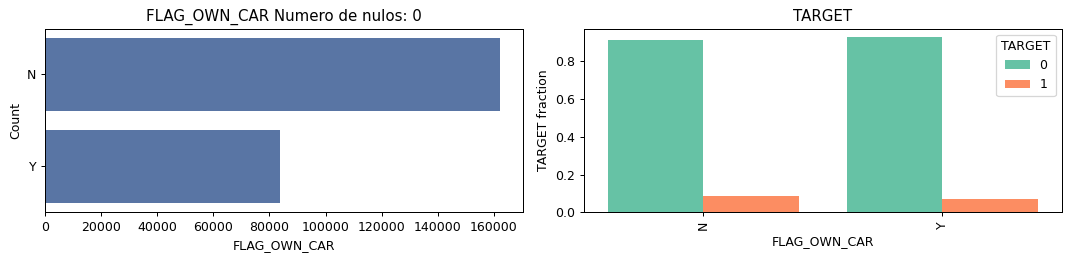

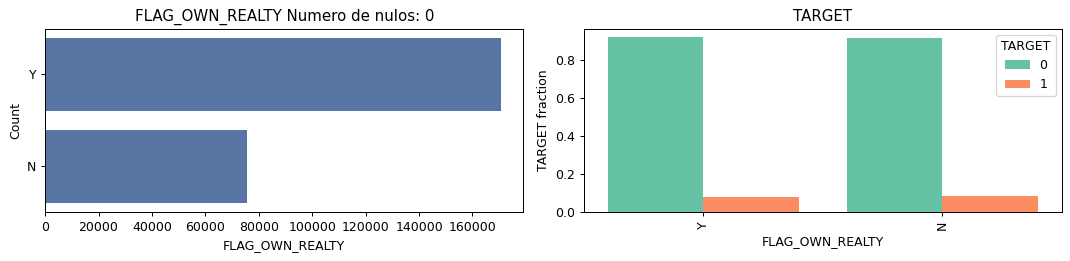

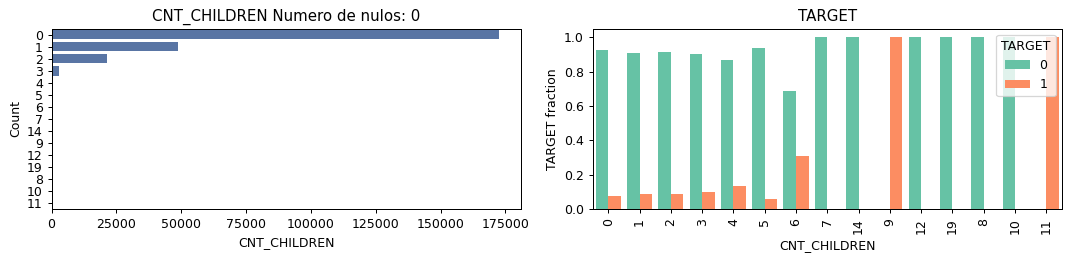

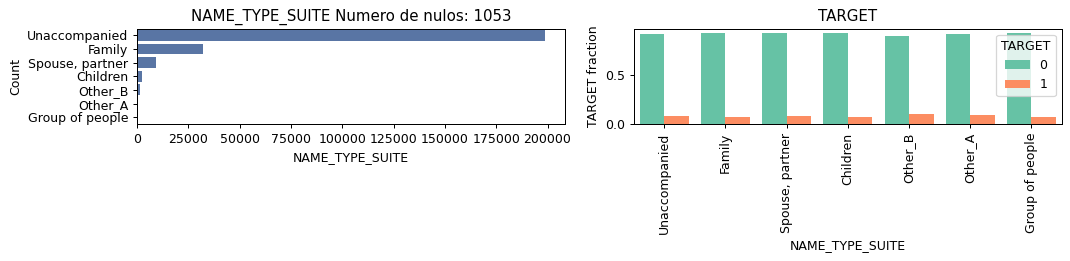

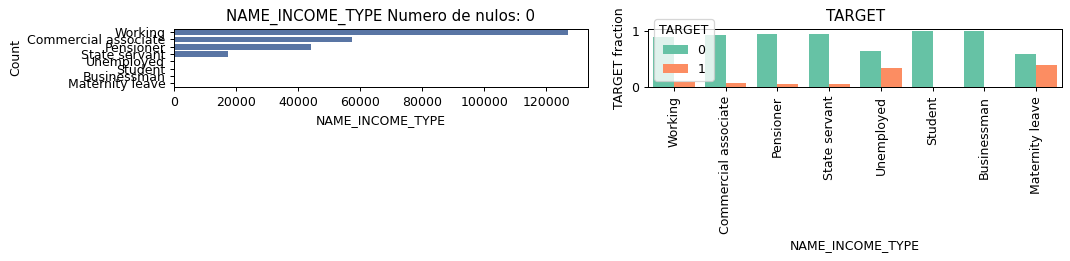

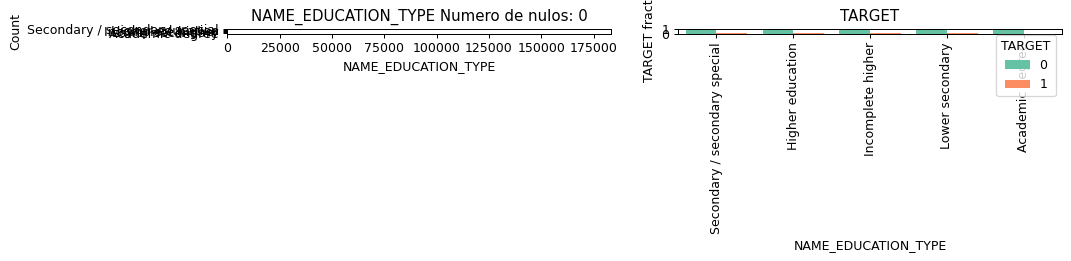

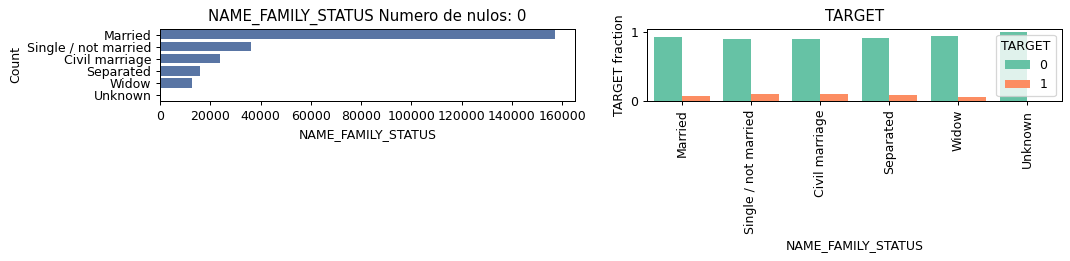

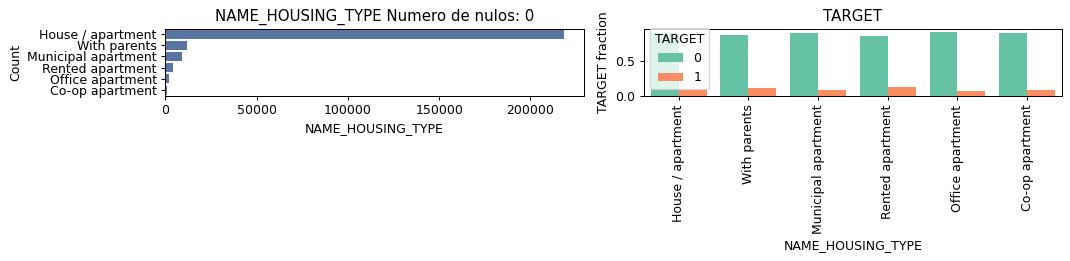

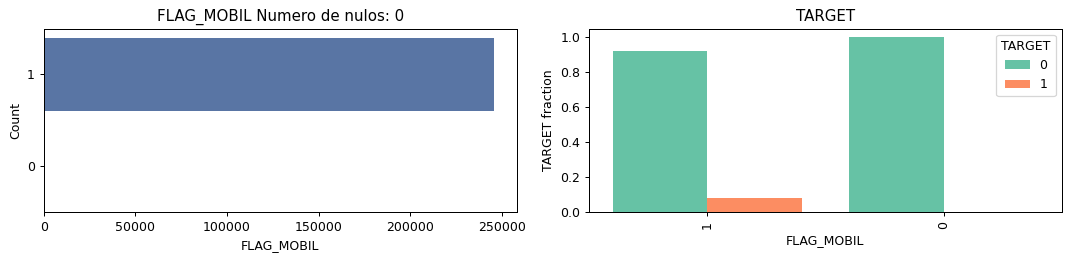

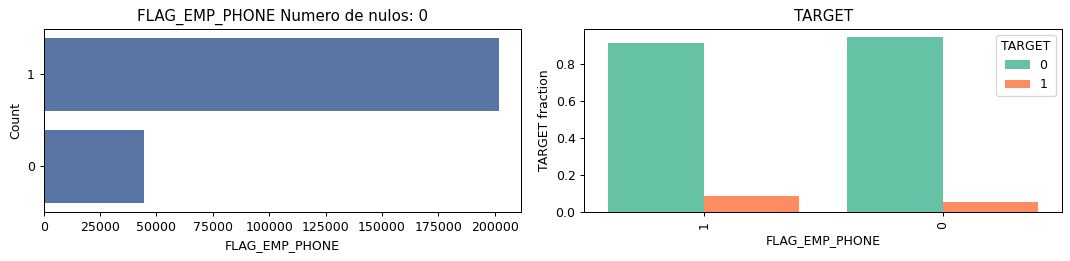

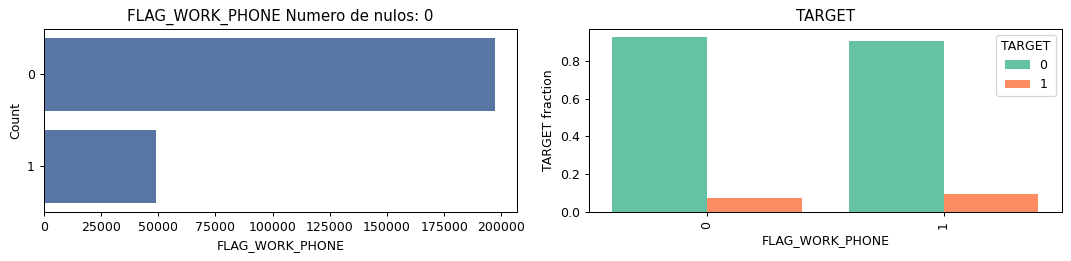

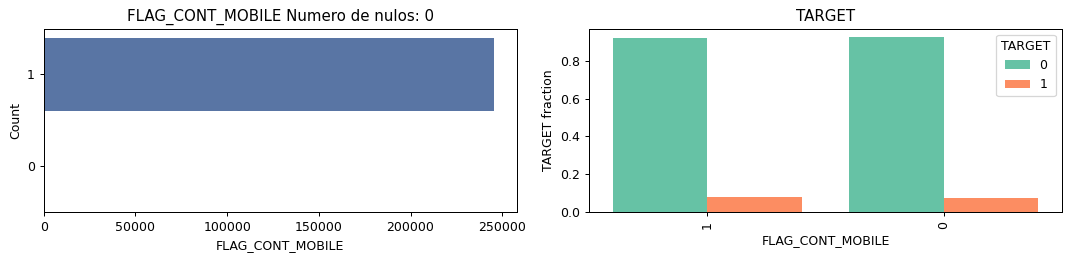

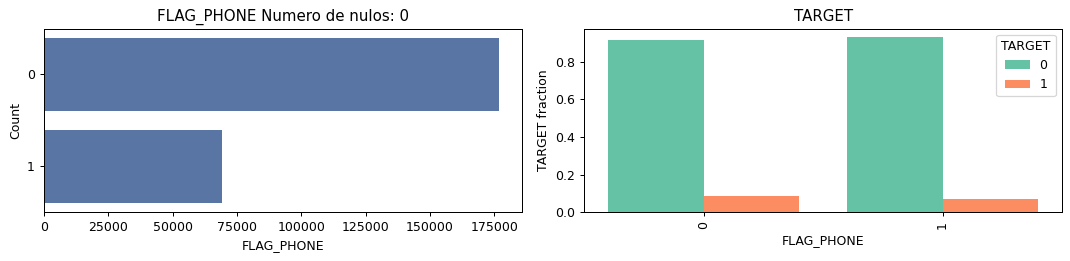

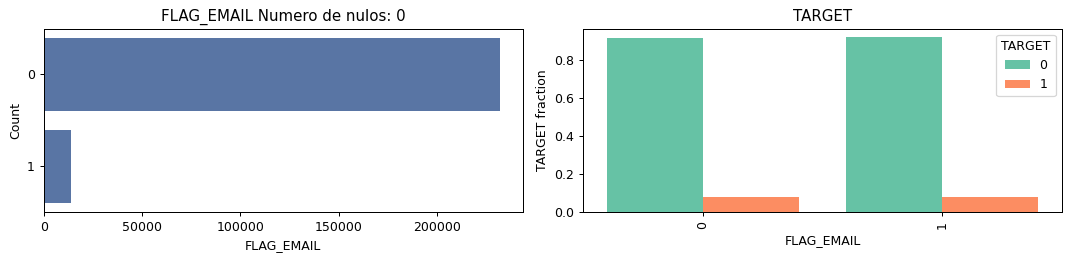

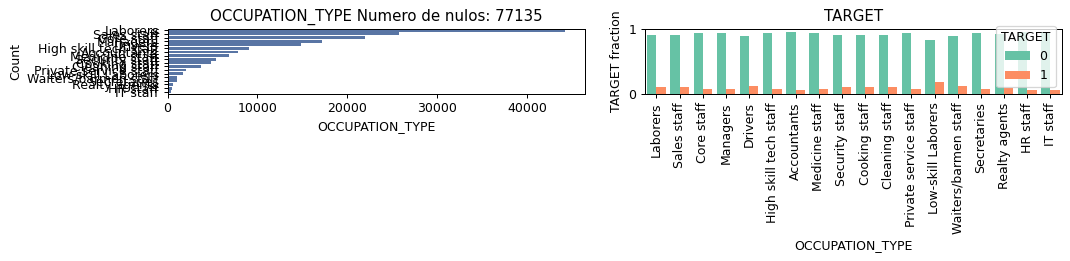

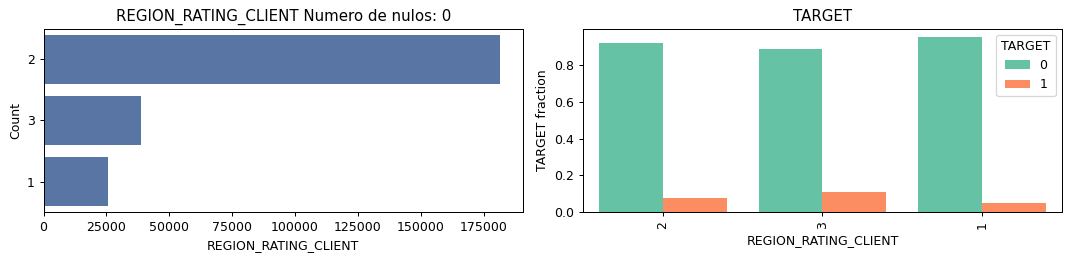

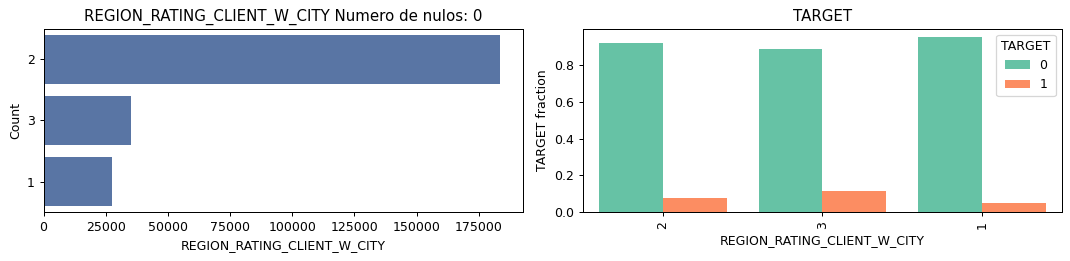

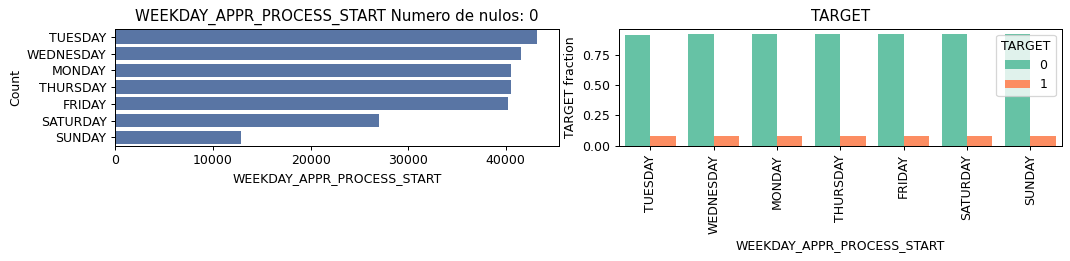

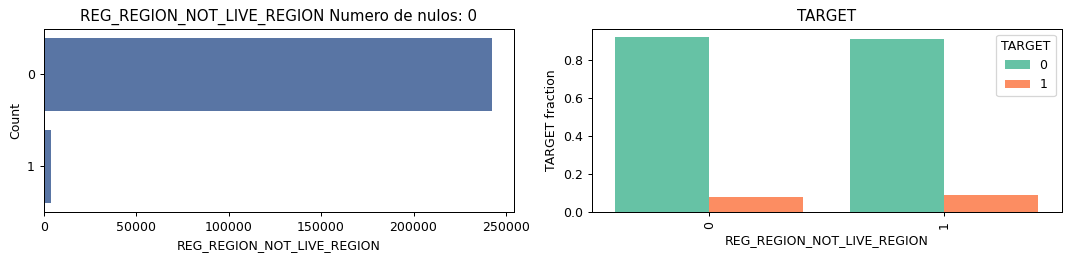

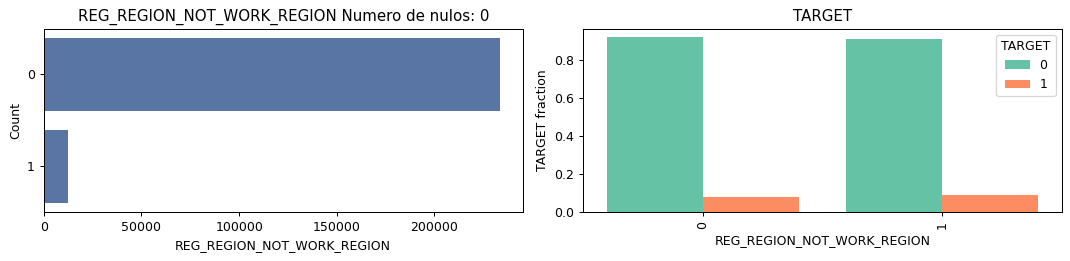

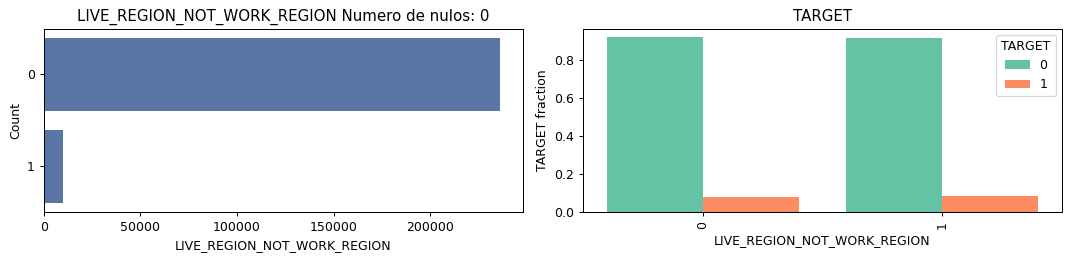

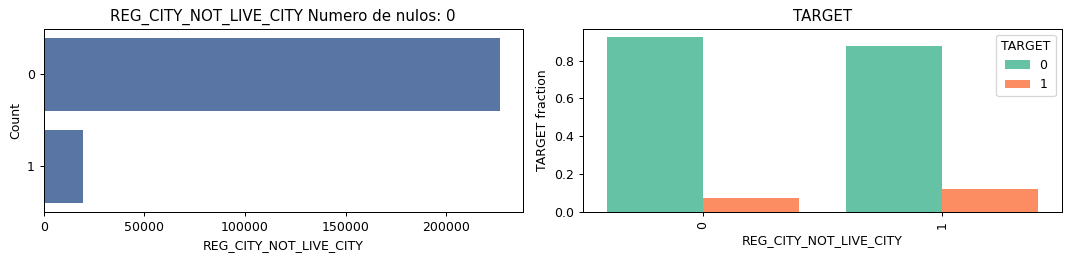

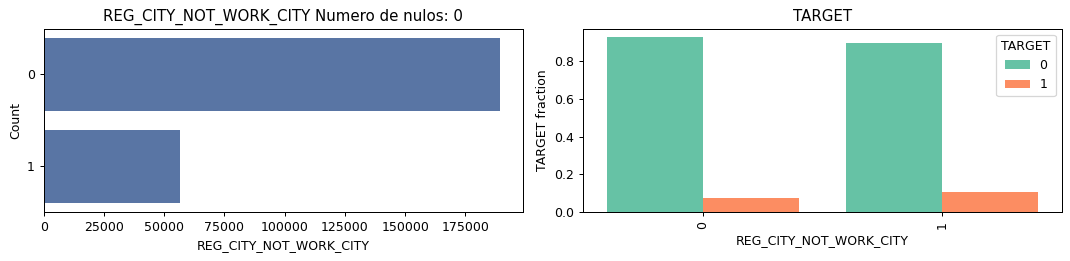

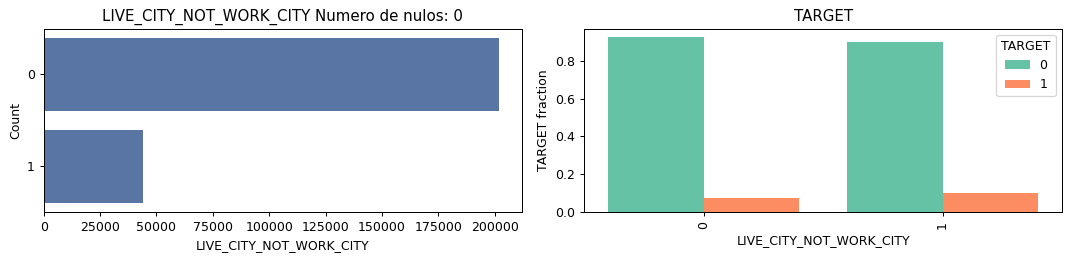

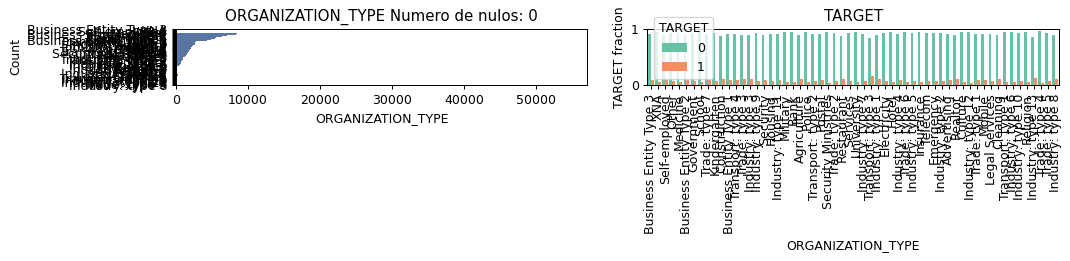

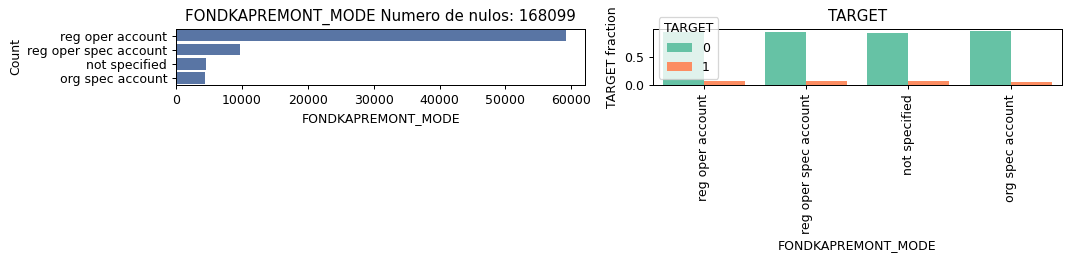

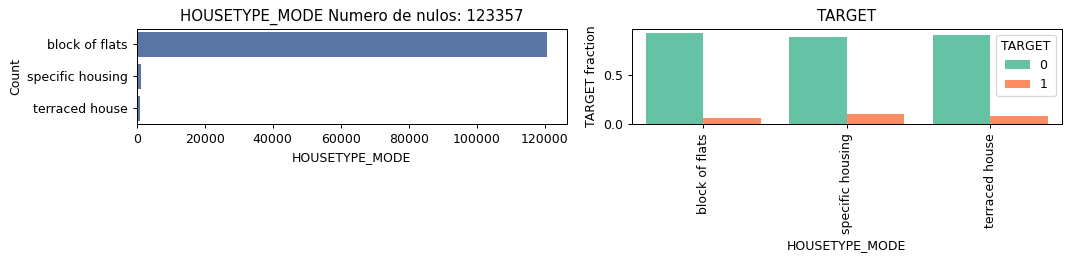

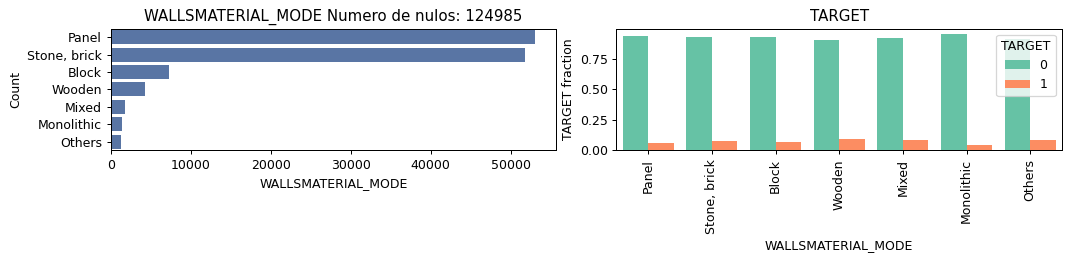

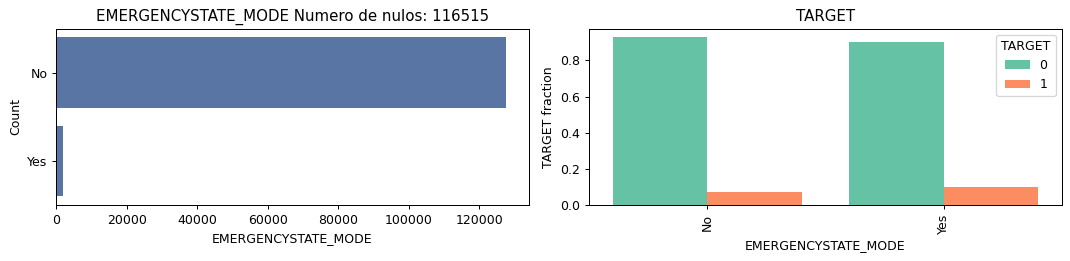

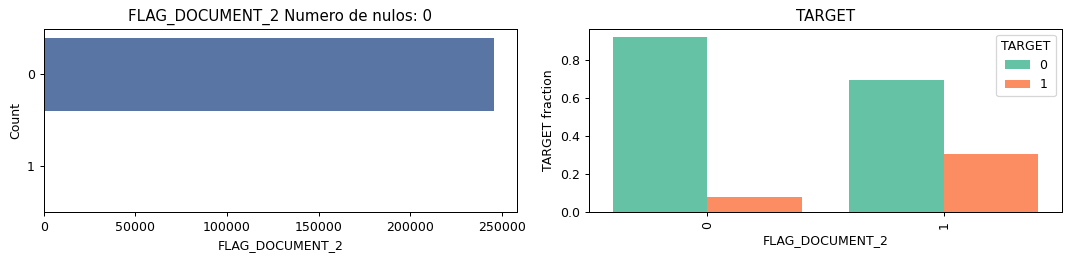

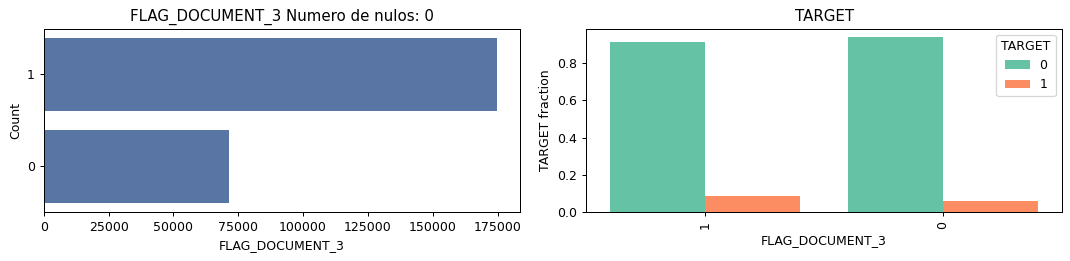

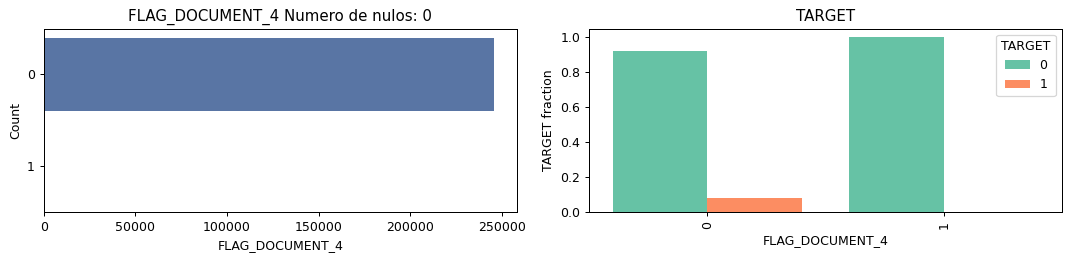

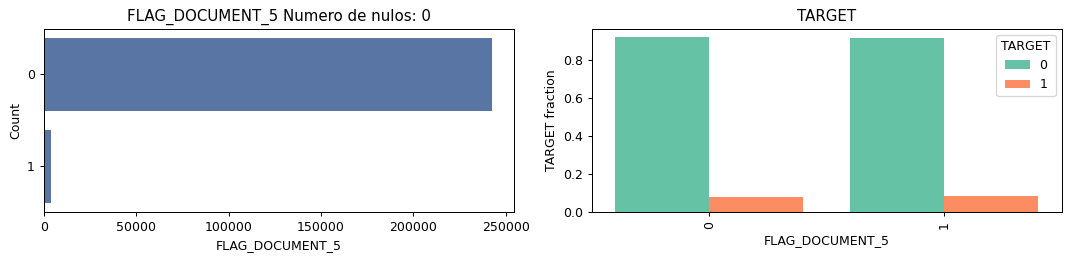

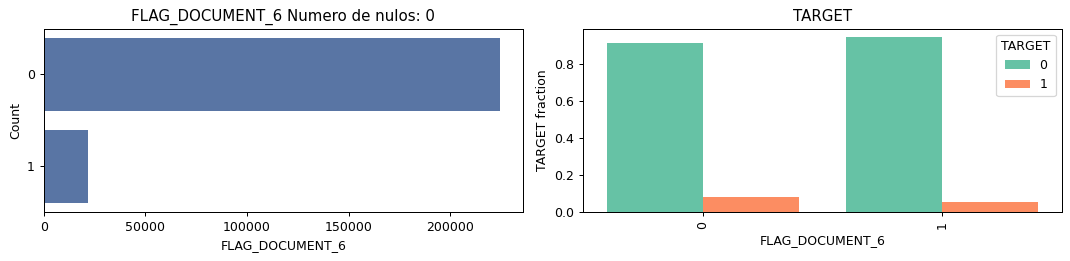

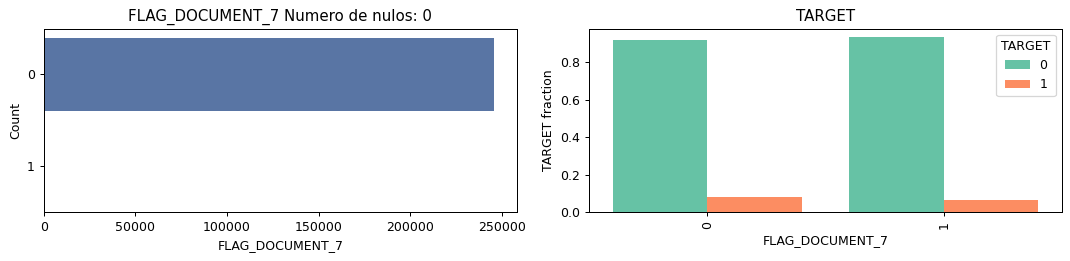

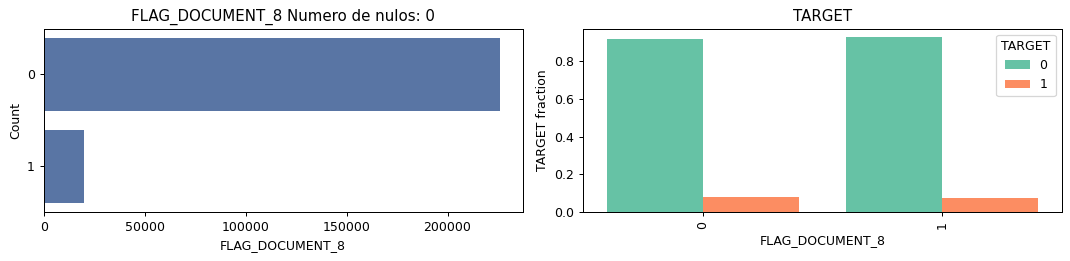

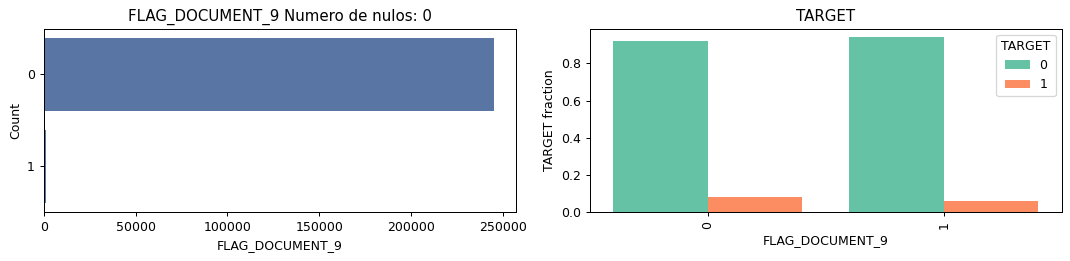

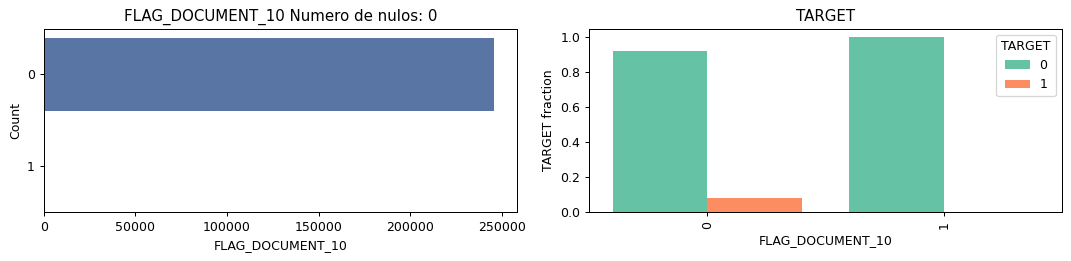

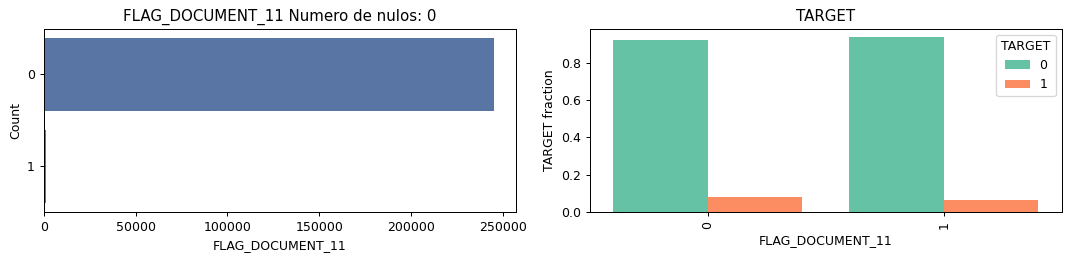

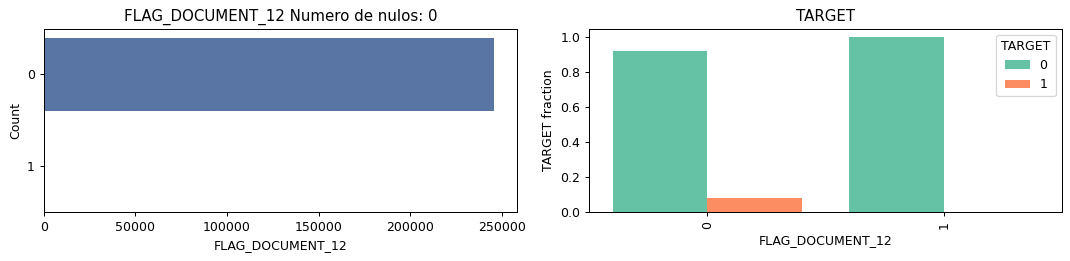

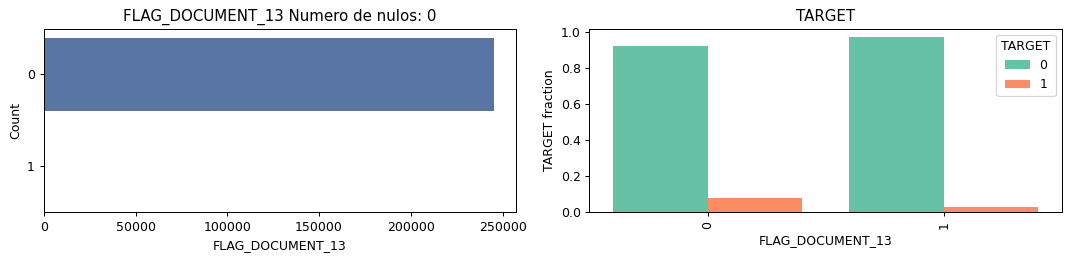

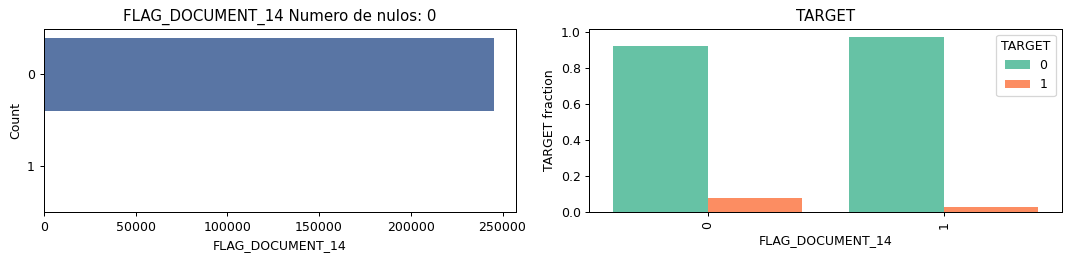

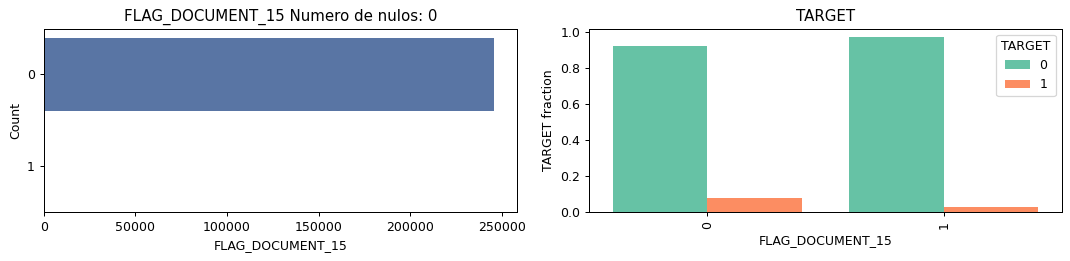

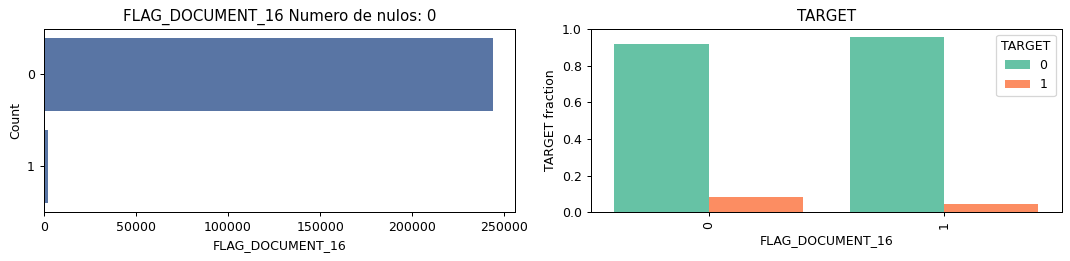

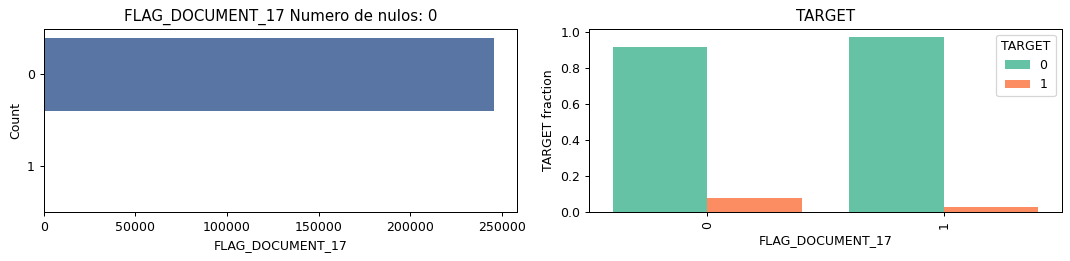

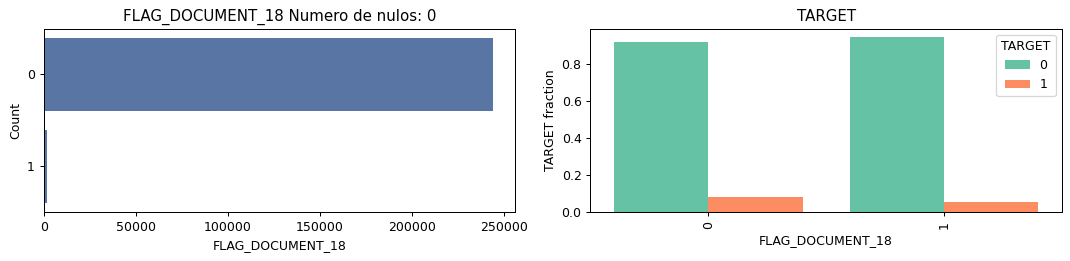

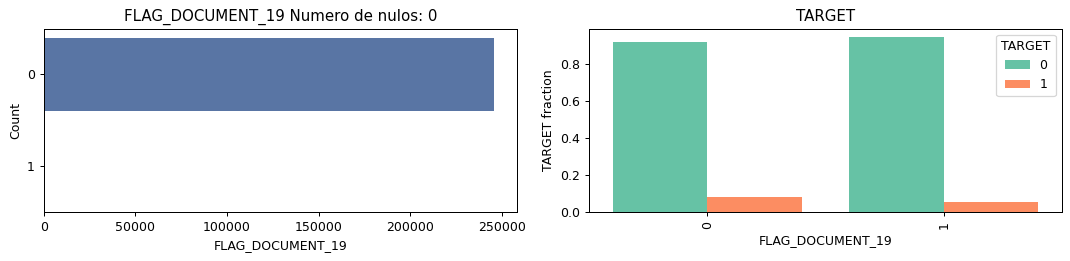

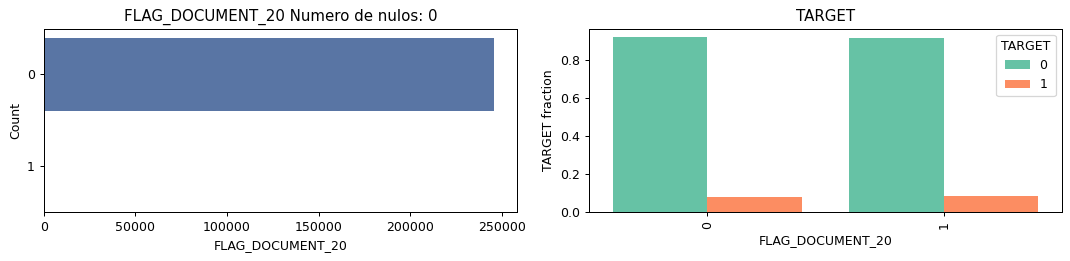

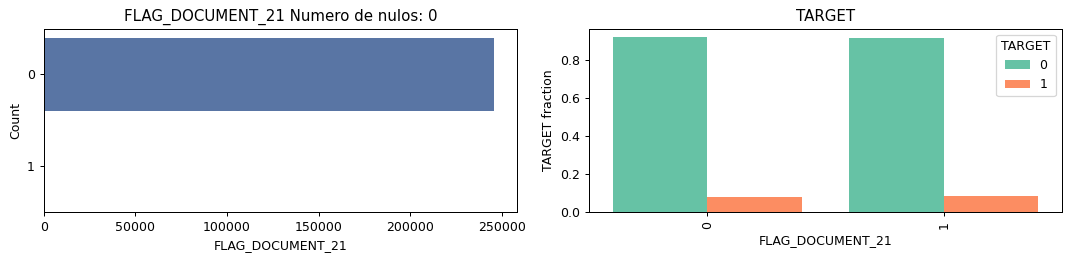

In [21]:
warnings.filterwarnings('ignore')
for i in list(pd_loan_train.columns):
    if (pd_loan_train[i].dtype!=float) & (i!='TARGET'):
        # print(i)
        funciones.plot_feature(pd_loan_train, col_name=i, isContinuous=False)

Para analizar las variables categóricas, inicio observando gráficos de barras, ya que son útiles para visualizar la distribución de las categorías y detectar posibles desbalances. Además, empleo gráficos de barras apiladas en función de la variable objetivo para analizar cómo se distribuyen las clases de `TARGET` entre las diferentes categorías. Si algunas categorías muestran una relación más marcada con la variable objetivo, esto puede indicar un mayor poder predictivo. También reviso la cantidad de valores nulos en estas variables, ya que su presencia puede afectar la calidad de los datos.

Es importante tener en cuenta que la variable objetivo está desbalanceada: el 91.93% de los casos corresponden a `TARGET` = 0 y solo el 8.07% a `TARGET`= 1. Este desequilibrio influye en la interpretación de los resultados y debe considerarse al realizar el análisis.

La primera variable analizada es el sexo del cliente. Aunque las diferencias son ligeras, se observa que los hombres, además de ser quienes solicitan menos préstamos, presentan una mayor probabilidad de enfrentar problemas con los pagos.

Una variable que destaca es el número de hijos de los clientes. Los datos revelan que los clientes con más hijos tienden a experimentar mayores dificultades para cumplir con los pagos. Sin embargo, dado que la mayoría de los clientes tiene entre 0 y 1 hijo, las conclusiones sobre aquellos con un número elevado de hijos se basan en una muestra limitada, lo que reduce su representatividad.

Otra variable relevante es el tipo de ingresos de los clientes. Los resultados muestran que las personas sin empleo y aquellas en baja por maternidad enfrentan mayores dificultades para pagar. Por el contrario, los clientes que son empresarios no presentan problemas significativos con sus pagos.

En cuanto a la ocupación, los gráficos revelan que los clientes con trabajos de baja cualificación (Low-Skill Laborers) tienen más dificultades para cumplir con sus pagos. Este hallazgo resalta el impacto de la estabilidad laboral y los niveles de ingreso en el comportamiento de pago.

La región de residencia también influye significativamente en la probabilidad de dificultades de pago. En particular, los clientes de la región 3 son los que presentan mayores problemas para cumplir con sus pagos, seguidos por los de la región 2. En contraste, los clientes de la región 1 son quienes tienen menos dificultades.

Otro aspecto interesante es la variable relacionada con el documento 2. Los datos indican que las personas que han entregado este documento tienen una mayor proporción de dificultades de pago. Sin embargo, dado que la mayoría de los clientes no han proporcionado este documento, esta conclusión podría no ser representativa del comportamiento general.

Por último, en las variables categóricas booleanas no he identificado información particularmente útil. Esto se debe a que, al tener solo dos valores posibles, su variabilidad es limitada, lo que dificulta la detección de patrones claros o relaciones significativas con la variable objetivo. 

Es muy importante destacar que los datos de tipo entero que he definido como categóricos, incluidas las variables booleanas, no presentan ningún valor nulo.

# Tratamiento de las variables continuas:

A continuación, se tratarán tres aspectos clave del análisis de los datos: los valores faltantes (missing), las correlaciones entre las variables continuas y los valores atípicos (outliers), con el objetivo de limpiar y entender mejor los datos antes de construir el modelo.

Primero, recuerdo cuales son las variables que he considerado como continuas: 

In [22]:
# Variables continuas
# ==============================================================================
list_var_continuous

['AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'CNT_FAM_MEMBERS',
 'HOUR_APPR_PROCESS_START',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONA

## Tratamiento de outliers:

Los valores outliers se pueden sustituir por la media, mediana o utilizando valores extremos como la media ± 3 veces la desviación estándar. 

Es importante destacar que, antes de tratar los outliers, se debe analizar su relación con la variable objetivo y comprender su contexto, ya que podrían representar casos relevantes o errores de medición que influyan en la predicción del modelo.

In [24]:
funciones.get_deviation_of_mean_perc(pd_loan_train, list_var_continuous, target='TARGET', multiplier=3)

0.0       1.0                      variable  sum_outlier_values  \
0    0.000000  1.000000              AMT_INCOME_TOTAL                2193   
1    0.943000  0.057000              AMT_INCOME_TOTAL                2193   
2    0.000000  1.000000                    AMT_CREDIT                2593   
3    0.957964  0.042036                    AMT_CREDIT                2593   
4    0.000000  1.000000                   AMT_ANNUITY                2353   
5    0.962176  0.037824                   AMT_ANNUITY                2353   
6    0.000000  1.000000               AMT_GOODS_PRICE                3322   
7    0.961770  0.038230               AMT_GOODS_PRICE                3322   
8    0.000000  1.000000    REGION_POPULATION_RELATIVE                6745   
9    0.959377  0.040623    REGION_POPULATION_RELATIVE                6745   
10   0.000000  1.000000             DAYS_REGISTRATION                 604   
11   0.953642  0.046358             DAYS_REGISTRATION                 604   
12   0.000000  1.000000                   OWN_CAR_AGE                2689   
13   0.923763  0.076237                   OWN_CAR_AGE                2689   
14   0.000000  1.000000               CNT_FAM_MEMBERS                3223   
15   0.898852  0.101148               CNT_FAM_MEMBERS                3223   
16   0.000000  1.000000       HOUR_APPR_PROCESS_START                 495   
17   0.896970  0.103030       HOUR_APPR_PROCESS_START                 495   
18   0.000000  1.000000                APARTMENTS_AVG                2389   
19   0.947677  0.052323                APARTMENTS_AVG                2389   
20   0.000000  1.000000              BASEMENTAREA_AVG                1577   
21   0.946734  0.053266              BASEMENTAREA_AVG                1577   
22   0.000000  1.000000   YEARS_BEGINEXPLUATATION_AVG                 544   
23   0.915441  0.084559   YEARS_BEGINEXPLUATATION_AVG                 544   
24   0.000000  1.000000               YEARS_BUILD_AVG                 970   
25   0.927835  0.072165               YEARS_BUILD_AVG                 970   
26   0.000000  1.000000                COMMONAREA_AVG                1355   
27   0.949077  0.050923                COMMONAREA_AVG                1355   
28   0.000000  1.000000                 ELEVATORS_AVG                1961   
29   0.952065  0.047935                 ELEVATORS_AVG                1961   
30   0.000000  1.000000                 ENTRANCES_AVG                1763   
31   0.936472  0.063528                 ENTRANCES_AVG                1763   
32   0.000000  1.000000                 FLOORSMAX_AVG                2095   
33   0.958473  0.041527                 FLOORSMAX_AVG                2095   
34   0.000000  1.000000                 FLOORSMIN_AVG                 464   
35   0.961207  0.038793                 FLOORSMIN_AVG                 464   
36   0.000000  1.000000                  LANDAREA_AVG                1662   
37   0.932611  0.067389                  LANDAREA_AVG                1662   
38   0.000000  1.000000          LIVINGAPARTMENTS_AVG                1402   
39   0.946505  0.053495          LIVINGAPARTMENTS_AVG                1402   
40   0.000000  1.000000                LIVINGAREA_AVG                2565   
41   0.946199  0.053801                LIVINGAREA_AVG                2565   
42   0.000000  1.000000       NONLIVINGAPARTMENTS_AVG                 568   
43   0.926056  0.073944       NONLIVINGAPARTMENTS_AVG                 568   
44   0.000000  1.000000             NONLIVINGAREA_AVG                1943   
45   0.951107  0.048893             NONLIVINGAREA_AVG                1943   
46   0.000000  1.000000               APARTMENTS_MODE                2405   
47   0.946778  0.053222               APARTMENTS_MODE                2405   
48   0.000000  1.000000             BASEMENTAREA_MODE                1637   
49   0.944411  0.055589             BASEMENTAREA_MODE                1637   
50   0.000000  1.000000  YEARS_BEGINEXPLUATATION_MODE                 533   
51   0

Tras el análisis exploratorio, he decidido, como primera iteración, no sustituir los valores atípicos, ya que es importante evaluar su impacto en el modelo. Esta decisión también se debe a la gran cantidad de outliers observados, algunos de los cuales superan el 2% de los datos. Se puede observar que el porcentaje de la variable objetivo en cada variable cambiará al no considerar los outliers. Una vez construido el modelo, puedo realizar iteraciones utilizando diferentes métodos de tratamiento para evaluar si estos mejoran el rendimiento

## Correlaciones:

En esta sección se analizarán las correlaciones entre las variables continuas utilizando la matriz de correlación de Pearson, que mide la fuerza y la dirección de una relación lineal entre dos variables numéricas. Los valores de Pearson oscilan entre -1 y 1, donde 1 indica una relación positiva perfecta, -1 una relación negativa perfecta, y 0 señala la ausencia de una relación lineal.



Es importante mencionar que se establece la autocorrelación en 0 para evitar distracción visual y centrar el análisis en relaciones entre distintas variables

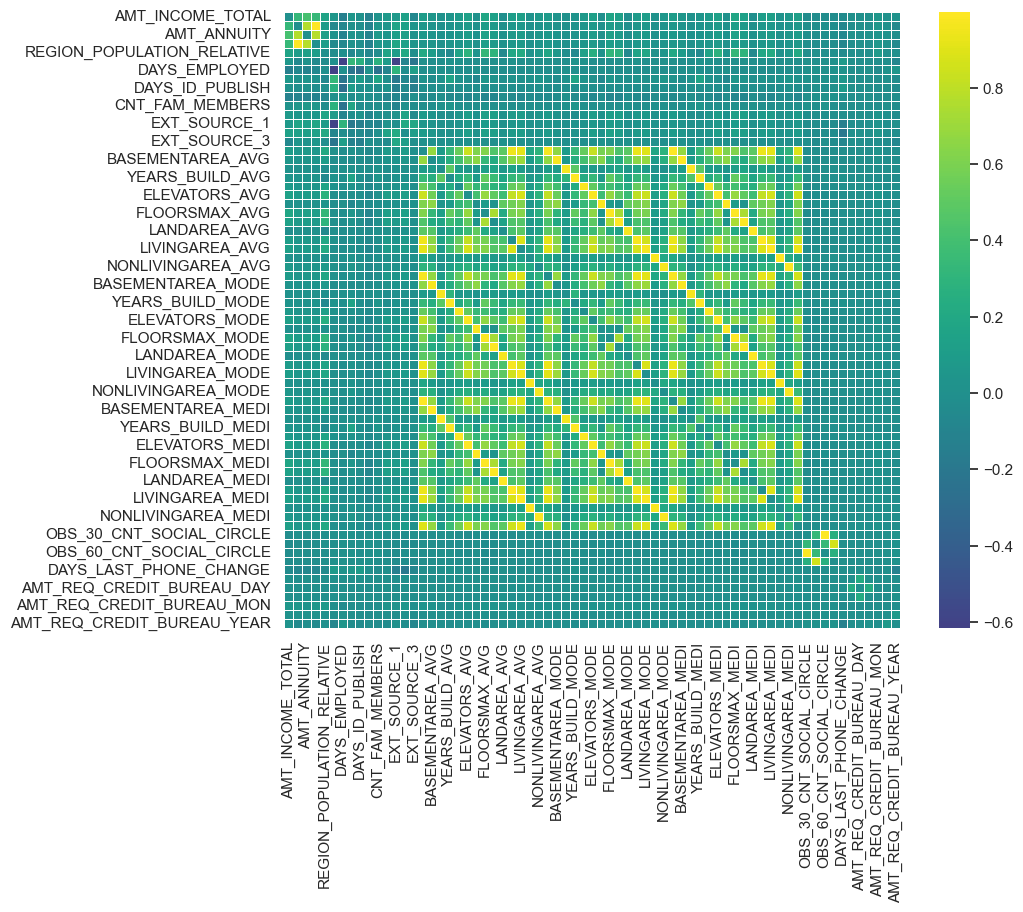

0

In [26]:
funciones.get_corr_matrix(dataset = pd_loan_train[list_var_continuous], 
                metodo='pearson', size_figure=[10,8])

En la matriz de correlación se pueden ver varias correlaciones de Pearson cercanas o iguales a 1, lo que indica que algunas variables están perfectamente correlacionadas. Esto podría ser una señal de que hay variables redundantes o derivadas de otras, lo que podría generar problemas de multicolinealidad en los modelos estadísticos.

Un patrón interesante es que las variables relacionadas con medidas como la media, mediana y moda de una misma característica muestran correlaciones cercanas a 1. Esto sugiere que estas variables podrían estar representando prácticamente la misma información.

Más adelante, se revisarán estas variables y, si es necesario, se eliminarán aquellas que sean idénticas o estén altamente correlacionadas para evitar que afecten los resultados del modelo.

En el caso de algoritmos basados en árboles, como XGBoost y Random Forest, la multicolinealidad no representa un problema mayor, ya que estos modelos no necesitan que las variables sean independientes entre sí para hacer predicciones. De hecho, son capaces de manejar variables correlacionadas de forma eficiente sin que esto afecte su rendimiento.

Sin embargo, en modelos lineales como los GLM (Modelos Lineales Generalizados), la multicolinealidad sí puede afectar la estabilidad e interpretación de los coeficientes. Esto ocurre porque la alta correlación entre variables puede inflar los errores estándar, generando estimaciones inexactas. En estos casos, será importante eliminar o reducir la colinealidad antes de entrenar el modelo.

In [27]:
# Correlación de Pearson variables continuas
# ==============================================================================

corr = pd_loan_train[list_var_continuous].corr('pearson')
new_corr = corr.abs()
new_corr.loc[:,:] = np.tril(new_corr, k=-1)
new_corr = new_corr.stack().to_frame('correlation').reset_index().sort_values(by='correlation', ascending=False)
new_corr[new_corr['correlation']>0.6]

level_0                       level_1  correlation
4198      OBS_60_CNT_SOCIAL_CIRCLE      OBS_30_CNT_SOCIAL_CIRCLE     0.998507
3192              YEARS_BUILD_MEDI               YEARS_BUILD_AVG     0.998433
3542                FLOORSMIN_MEDI                 FLOORSMIN_AVG     0.997350
3472                FLOORSMAX_MEDI                 FLOORSMAX_AVG     0.996987
3402                ENTRANCES_MEDI                 ENTRANCES_AVG     0.996868
3332                ELEVATORS_MEDI                 ELEVATORS_AVG     0.996301
3262               COMMONAREA_MEDI                COMMONAREA_AVG     0.995773
3752               LIVINGAREA_MEDI                LIVINGAREA_AVG     0.995569
3122  YEARS_BEGINEXPLUATATION_MEDI   YEARS_BEGINEXPLUATATION_AVG     0.994784
2982               APARTMENTS_MEDI                APARTMENTS_AVG     0.994586
3052             BASEMENTAREA_MEDI              BASEMENTAREA_AVG     0.994424
3822      NONLIVINGAPARTMENTS_MEDI       NONLIVINGAPARTMENTS_AVG     0.994315
3682         LIVINGAPARTMENTS_MEDI          LIVINGAPARTMENTS_AVG     0.992994
3892            NONLIVINGAREA_MEDI             NONLIVINGAREA_AVG     0.991681
3612                 LANDAREA_MEDI                  LANDAREA_AVG     0.991270
3206              YEARS_BUILD_MEDI              YEARS_BUILD_MODE     0.989588
2226              YEARS_BUILD_MODE               YEARS_BUILD_AVG     0.989509
3486                FLOORSMAX_MEDI                FLOORSMAX_MODE     0.988376
3556                FLOORSMIN_MEDI                FLOORSMIN_MODE     0.988346
208                AMT_GOODS_PRICE                    AMT_CREDIT     0.986961
2576                FLOORSMIN_MODE                 FLOORSMIN_AVG     0.985898
2506                FLOORSMAX_MODE                 FLOORSMAX_AVG     0.985728
3346                ELEVATORS_MEDI                ELEVATORS_MODE     0.983063
3416                ENTRANCES_MEDI                ENTRANCES_MODE     0.980799
3626                 LANDAREA_MEDI                 LANDAREA_MODE     0.980337
3276               COMMONAREA_MEDI               COMMONAREA_MODE     0.980305
3836      NONLIVINGAPARTMENTS_MEDI      NONLIVINGAPARTMENTS_MODE     0.979433
2366                ELEVATORS_MODE                 ELEVATORS_AVG     0.979193
2436                ENTRANCES_MODE                 ENTRANCES_AVG     0.977770
3066             BASEMENTAREA_MEDI             BASEMENTAREA_MODE     0.977537
2296               COMMONAREA_MODE                COMMONAREA_AVG     0.977306
2996               APARTMENTS_MEDI               APARTMENTS_MODE     0.977249
3906            NONLIVINGAREA_MEDI            NONLIVINGAREA_MODE     0.975850
3696         LIVINGAPARTMENTS_MEDI         LIVINGAPARTMENTS_MODE     0.975408
3766               LIVINGAREA_MEDI               LIVINGAREA_MODE     0.974808
2856      NONLIVINGAPARTMENTS_MODE       NONLIVINGAPARTMENTS_AVG     0.973941
2156  YEARS_BEGINEXPLUATATION_MODE   YEARS_BEGINEXPLUATATION_AVG     0.973210
2086             BASEMENTAREA_MODE              BASEMENTAREA_AVG     0.973177
2646                 LANDAREA_MODE                  LANDAREA_AVG     0.973008
2016               APARTMENTS_MODE                APARTMENTS_AVG     0.972709
2786               LIVINGAREA_MODE                LIVINGAREA_AVG     0.972126
2716         LIVINGAPARTMENTS_MODE          LIVINGAPARTMENTS_AVG     0.969061
2926            NONLIVINGAREA_MODE             NONLIVINGAREA_AVG     0.967384
3136  YEARS_BEGINEXPLUATATION_MEDI  YEARS_BEGINEXPLUATATION_MODE     0.966340
1740          LIVINGAPARTMENTS_AVG                APARTMENTS_AVG     0.942701
3700         LIVINGAPARTMENTS_MEDI               APARTMENTS_MEDI     0.941122
3672         LIVINGAPARTMENTS_MEDI                APARTMENTS_AVG     0.940545
2720         LIVINGAPARTMENTS_MODE               APARTMENTS_MODE     0.937027
2992               APARTMENTS_MEDI          LIVINGAPARTMENTS_AVG     0.933402
3006               APARTMENTS_MEDI         LIVINGAPARTMENTS_MODE     0.931129
2706         LIVINGAPARTMENTS_MODE               

He optado por no eliminar las variables con altas correlaciones. Estas podrían ser candidatas a eliminación en pasos posteriores. Si en etapas futuras se utiliza un algoritmo que requiera la eliminación de la colinealidad, procederemos a eliminar las variables más correlacionadas para evitar posibles problemas en los resultados del modelo.

Por otro lado, comprobar la correlación de Spearman puede ser útil, ya que mide relaciones monótonas no lineales entre variables. Esto nos permitirá identificar patrones que podrían ser pasados por alto con Pearson.

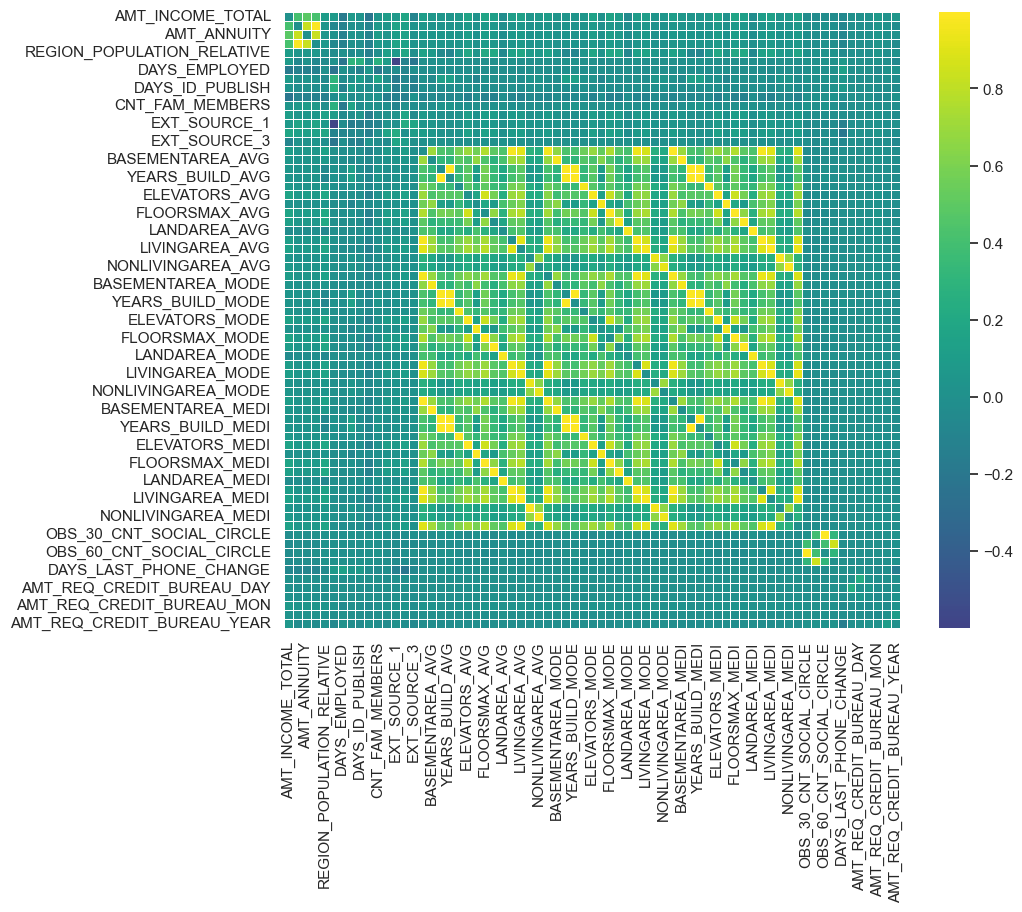

0

In [28]:
funciones.get_corr_matrix(dataset = pd_loan_train[list_var_continuous], 
                metodo='spearman', size_figure=[10,8])

In [29]:
# Correlación de Spearman variables continuas
# ==============================================================================

corr = pd_loan_train[list_var_continuous].corr('spearman')
new_corr = corr.abs()
new_corr.loc[:,:] = np.tril(new_corr, k=-1) # below main lower triangle of an array
new_corr = new_corr.stack().to_frame('correlation').reset_index().sort_values(by='correlation', ascending=False)
new_corr[new_corr['correlation']>0.6]

level_0                       level_1  correlation
3192              YEARS_BUILD_MEDI               YEARS_BUILD_AVG     0.998426
3122  YEARS_BEGINEXPLUATATION_MEDI   YEARS_BEGINEXPLUATATION_AVG     0.997404
4198      OBS_60_CNT_SOCIAL_CIRCLE      OBS_30_CNT_SOCIAL_CIRCLE     0.997264
3612                 LANDAREA_MEDI                  LANDAREA_AVG     0.996263
3682         LIVINGAPARTMENTS_MEDI          LIVINGAPARTMENTS_AVG     0.996227
3542                FLOORSMIN_MEDI                 FLOORSMIN_AVG     0.996177
3262               COMMONAREA_MEDI                COMMONAREA_AVG     0.995847
3752               LIVINGAREA_MEDI                LIVINGAREA_AVG     0.995487
2982               APARTMENTS_MEDI                APARTMENTS_AVG     0.995211
3472                FLOORSMAX_MEDI                 FLOORSMAX_AVG     0.994834
3052             BASEMENTAREA_MEDI              BASEMENTAREA_AVG     0.994811
3402                ENTRANCES_MEDI                 ENTRANCES_AVG     0.993370
3332                ELEVATORS_MEDI                 ELEVATORS_AVG     0.991105
3206              YEARS_BUILD_MEDI              YEARS_BUILD_MODE     0.988352
2226              YEARS_BUILD_MODE               YEARS_BUILD_AVG     0.988016
1259               YEARS_BUILD_AVG   YEARS_BEGINEXPLUATATION_AVG     0.986683
3486                FLOORSMAX_MEDI                FLOORSMAX_MODE     0.986527
3556                FLOORSMIN_MEDI                FLOORSMIN_MODE     0.986364
3219              YEARS_BUILD_MEDI  YEARS_BEGINEXPLUATATION_MEDI     0.985764
3136  YEARS_BEGINEXPLUATATION_MEDI  YEARS_BEGINEXPLUATATION_MODE     0.985673
3191              YEARS_BUILD_MEDI   YEARS_BEGINEXPLUATATION_AVG     0.985239
2156  YEARS_BEGINEXPLUATATION_MODE   YEARS_BEGINEXPLUATATION_AVG     0.985236
208                AMT_GOODS_PRICE                    AMT_CREDIT     0.984931
3123  YEARS_BEGINEXPLUATATION_MEDI               YEARS_BUILD_AVG     0.984369
2576                FLOORSMIN_MODE                 FLOORSMIN_AVG     0.982634
3822      NONLIVINGAPARTMENTS_MEDI       NONLIVINGAPARTMENTS_AVG     0.982089
2506                FLOORSMAX_MODE                 FLOORSMAX_AVG     0.981666
3892            NONLIVINGAREA_MEDI             NONLIVINGAREA_AVG     0.980895
2239              YEARS_BUILD_MODE  YEARS_BEGINEXPLUATATION_MODE     0.979828
3346                ELEVATORS_MEDI                ELEVATORS_MODE     0.977948
2225              YEARS_BUILD_MODE   YEARS_BEGINEXPLUATATION_AVG     0.975014
3137  YEARS_BEGINEXPLUATATION_MEDI              YEARS_BUILD_MODE     0.974845
3696         LIVINGAPARTMENTS_MEDI         LIVINGAPARTMENTS_MODE     0.973776
1740          LIVINGAPARTMENTS_AVG                APARTMENTS_AVG     0.972337
3276               COMMONAREA_MEDI               COMMONAREA_MODE     0.971266
3626                 LANDAREA_MEDI                 LANDAREA_MODE     0.970980
2996               APARTMENTS_MEDI               APARTMENTS_MODE     0.970013
2716         LIVINGAPARTMENTS_MODE          LIVINGAPARTMENTS_AVG     0.969773
3700         LIVINGAPARTMENTS_MEDI               APARTMENTS_MEDI     0.969457
3205              YEARS_BUILD_MEDI  YEARS_BEGINEXPLUATATION_MODE     0.969325
3766               LIVINGAREA_MEDI               LIVINGAREA_MODE     0.969151
2366                ELEVATORS_MODE                 ELEVATORS_AVG     0.969089
2157  YEARS_BEGINEXPLUATATION_MODE               YEARS_BUILD_AVG     0.968941
3672         LIVINGAPARTMENTS_MEDI                APARTMENTS_AVG     0.968643
2646                 LANDAREA_MODE                  LANDAREA_AVG     0.967403
2992               APARTMENTS_MEDI          LIVINGAPARTMENTS_AVG     0.966373
2296               COMMONAREA_MODE                COMMONAREA_AVG     0.966022
3416                ENTRANCES_MEDI                ENTRANCES_MODE     0.965282
2016               APARTMENTS_MODE                APARTMENTS_AVG     0.964732
2786               LIVINGAREA_MODE                LIVINGAREA_AVG     0.964095
3066             BASEMENTAREA_MEDI             BA

La matriz de correlación de Spearman muestra relaciones monótonas, ya sean lineales o no lineales, y tiene la ventaja de ser menos sensible a los outliers. Por otro lado, la matriz de correlación de Pearson está enfocada en relaciones lineales. Ambas matrices brindan información útil sobre las dependencias entre las variables.

Al comparar ambas matrices, se puede ver que las relaciones entre las variables son bastante similares tanto en Pearson como en Spearman, lo que sugiere que la mayoría de las relaciones son monótonas. Sin embargo, en la matriz de Spearman se detectan algunas relaciones que no se habían visto en Pearson, lo que indica que existen patrones no lineales en los datos que la correlación lineal no logra captar.

## Tratamiento de valores nulos:

Antes de decidir cómo manejar los valores nulos, es fundamental analizar su distribución en relación con la variable objetivo. Específicamente, es útil determinar si los valores faltantes se concentran en una clase específica de la variable objetivo o si su distribución es uniforme.

In [30]:
# Variables continuas
# ==============================================================================
list_var_continuous

['AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'CNT_FAM_MEMBERS',
 'HOUR_APPR_PROCESS_START',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONA

In [32]:
funciones.get_percent_null_values_target(pd_loan_train, list_var_continuous, target='TARGET')

0         1                      variable  sum_null_values  \
0   1.000000  0.000000                   AMT_ANNUITY               10   
1   0.921397  0.078603               AMT_GOODS_PRICE              229   
2   0.914958  0.085042                   OWN_CAR_AGE           162379   
3   1.000000  0.000000               CNT_FAM_MEMBERS                1   
4   0.914898  0.085102                  EXT_SOURCE_1           138763   
5   0.921305  0.078695                  EXT_SOURCE_2              521   
6   0.907037  0.092963                  EXT_SOURCE_3            48826   
7   0.908635  0.091365                APARTMENTS_AVG           124774   
8   0.911045  0.088955              BASEMENTAREA_AVG           143904   
9   0.908013  0.091987   YEARS_BEGINEXPLUATATION_AVG           119930   
10  0.913224  0.086776               YEARS_BUILD_AVG           163466   
11  0.914296  0.085704                COMMONAREA_AVG           171765   
12  0.909062  0.090938                 ELEVATORS_AVG           130969   
13  0.908334  0.091666                 ENTRANCES_AVG           123764   
14  0.908227  0.091773                 FLOORSMAX_AVG           122356   
15  0.913764  0.086236                 FLOORSMIN_AVG           166833   
16  0.911874  0.088126                  LANDAREA_AVG           145984   
17  0.913928  0.086072          LIVINGAPARTMENTS_AVG           168103   
18  0.908724  0.091276                LIVINGAREA_AVG           123428   
19  0.914332  0.085668       NONLIVINGAPARTMENTS_AVG           170752   
20  0.909811  0.090189             NONLIVINGAREA_AVG           135626   
21  0.908635  0.091365               APARTMENTS_MODE           124774   
22  0.911045  0.088955             BASEMENTAREA_MODE           143904   
23  0.908013  0.091987  YEARS_BEGINEXPLUATATION_MODE           119930   
24  0.913224  0.086776              YEARS_BUILD_MODE           163466   
25  0.914296  0.085704               COMMONAREA_MODE           171765   
26  0.909062  0.090938                ELEVATORS_MODE           130969   
27  0.908334  0.091666                ENTRANCES_MODE           123764   
28  0.908227  0.091773                FLOORSMAX_MODE           122356   
29  0.913764  0.086236                FLOORSMIN_MODE           166833   
30  0.911874  0.088126                 LANDAREA_MODE           145984   
31  0.913928  0.086072         LIVINGAPARTMENTS_MODE           168103   
32  0.908724  0.091276               LIVINGAREA_MODE           123428   
33  0.914332  0.085668      NONLIVINGAPARTMENTS_MODE           170752   
34  0.909811  0.090189            NONLIVINGAREA_MODE           135626   
35  0.908635  0.091365               APARTMENTS_MEDI           124774   
36  0.911045  0.088955             BASEMENTAREA_MEDI           143904   
37  0.908013  0.091987  YEARS_BEGINEXPLUATATION_MEDI           119930   
38  0.913224  0.086776              YEARS_BUILD_MEDI           163466   
39  0.914296  0.085704               COMMONAREA_MEDI           171765   
40  0.909062  0.090938                ELEVATORS_MEDI           130969   
41  0.908334  0.091666                ENTRANCES_MEDI           123764   
42  0.908227  0.091773                FLOORSMAX_MEDI           122356   
43  0.913764  0.086236                FLOORSMIN_MEDI           166833   
44  0.911874  0.088126                 LANDAREA_MEDI           145984   
45  0.913928  0.086072         LIVINGAPARTMENTS_MEDI           168103   
46  0.908724  0.091276               LIVINGAREA_MEDI           123428   
47  0.914332  0.085668      NONLIVINGAPARTMENTS_MEDI           170752   
48  0.909811  0.090189            NONLIVINGAREA_MEDI           135626   
49  0.907681  0.092319                TOTALAREA_MODE           118675   
50  0.961538  0.038462      OBS_30_CNT_SOCIAL_CIRCLE              832   
51  0.961538  0.038462      DEF_30_CNT_SOCIAL_CIRCLE              832   
52  0.961538  0.038462      OBS_60_CNT_SOCIAL_CIRCLE              832   
53  0.961538  0.038462      DEF_60_CNT_SOCIAL_CIRCLE              832

Como se comentó en el notebook anterior, el muestreo está desbalanceado, con la mayoría de los clientes sin dificultades para pagar el préstamo. Además, los valores faltantes se concentran principalmente en la clase 0 de la variable objetivo (clientes sin problemas de pago), siguiendo la misma tónica del desbalance presente en los datos.

Dado que al principio no cuento con suficiente contexto sobre las variables, se pueden emplear diferentes enfoques y comparar los resultados del modelo. Las opciones son las siguientes:

- Opción 0: Algunos algoritmos pueden manejar valores faltantes directamente, sin necesidad de imputarlos.

- Opción 1: Eliminar filas con valores nulos. No obstante, esta opción no es ideal en mi caso, ya que, como se ha observado, hay una cantidad significativa de filas con datos faltantes.

- Opción 2: Imputar los valores faltantes mediante técnicas estadísticas como la media, mediana, máximo, mínimo o incluso valores extremos.

- Opción 3: Rellenar los valores faltantes utilizando modelos de regresión, como KNN, regresión lineal o XGBoost. Sin embargo, este enfoque podría implicar un alto costo computacional y requiere cuidado para evitar el sobreajuste.


En este trabajo he optado por la opción 2 para imputar los valores faltantes utilizando la media o mediana. Esto es ideal para completar los datos sin recurrir a métodos costosos ni distorsionar su distribución. Descarto el uso de valores extremos, ya que las hay columnas que representan diferencias de tiempo, con valores tanto negativos como positivos. Además, Utilizar extremos podría introducir sesgos y afectar la coherencia del análisis.

Por lo tanto, imputar los valores faltantes con la media o la mediana permite mantener la coherencia y el equilibrio de las columnas, asegurando que los valores reemplazados sean representativos de la tendencia general de los datos sin introducir sesgos indebidos.

Es importante recordar que los valores faltantes en el conjunto de test se imputan utilizando la media calculada a partir del conjunto de train.

In [33]:
pd_loan_train[list_var_continuous] = pd_loan_train[list_var_continuous].apply(lambda x: x.fillna(x.median()))
pd_loan_test[list_var_continuous] = pd_loan_test[list_var_continuous].apply(lambda x: x.fillna(x.median()))

In [34]:
pd_loan_train[list_var_continuous]

AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
253977              405000.0    904500.0      38322.0         904500.0   
387015              202500.0    227520.0       8707.5         180000.0   
184784              225000.0    462825.0      33808.5         378000.0   
284885              135000.0    592560.0      28638.0         450000.0   
146800              225000.0    927252.0      25627.5         774000.0   
...                      ...         ...          ...              ...   
141125              148500.0    814041.0      23931.0         679500.0   
425798              135000.0   1620000.0      56308.5        1620000.0   
401809              135000.0    495000.0      25402.5         495000.0   
325030              112500.0    679500.0      19998.0         679500.0   
221487              144000.0    521280.0      23089.5         450000.0   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
253977                        0.015221    -17192.0        -5385.0   
387015                        0.007120    -19885.0         -627.0   
184784                        0.072508    -17351.0        -9975.0   
284885                        0.032561    -15563.0        -2836.0   
146800                        0.016612    -15103.0        -1629.0   
...                                ...         ...            ...   
141125                        0.025164    -16546.0        -5329.0   
425798                        0.046220    -16370.0         -935.0   
401809                        0.028663     -8834.0         -957.0   
325030                        0.019689    -18439.0        -2920.0   
221487                        0.030755    -23264.0       365243.0   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  CNT_FAM_MEMBERS  \
SK_ID_CURR                                                                     
253977                 -125.0           -738.0          2.0              2.0   
387015                -7730.0          -3437.0          9.0              2.0   
184784                -8836.0           -886.0          5.0              2.0   
284885                -7890.0          -4519.0          9.0              2.0   
146800                -3260.0          -3846.0          1.0              3.0   
...                       ...              ...          ...              ...   
141125                -4705.0            -93.0          7.0              1.0   
425798                -6868.0          -3648.0          9.0              3.0   
401809                -3380.0          -1508.0          9.0              1.0   
325030                -8460.0          -1900.0          9.0              2.0   
221487                 -467.0          -3124.0         12.0              2.0   

            HOUR_APPR_PROCESS_START  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  \
SK_ID_CURR                                                                      
253977                          9.0      0.650515      0.498739      0.411849   
387015                          7.0      0.506005      0.645398      0.385915   
184784                         14.0      0.742348      0.716670      0.265049   
284885                         13.0      0.506005      0.800211      0.537070   
146800                         18.0      0.506005      0.221765      0.260856   
...                             ...           ...           ...           ...   
141125                          8.0      0.506005      0.643063      0.406617   
425798                         14.0      0.719393      0.688328      0.465069   
401809                         15.0      0.274011      0.515539      0.537070   
325030                         11.0      0.862565      0.172498      0.537070   
221487                         16.0      0.506005      0.700755      0.759712   

            APARTMENTS_AVG  BASEMENTAREA_AVG  YEARS_BEGI

In [35]:
# Dimensión del dataset de entrenamiento
# ==============================================================================
pd_loan_train.shape

(246008, 121)

Ahora verificamos que no hay variables con valores nulos, confirmando que el reemplazo se ha realizado con éxito.

In [36]:
funciones.get_percent_null_values_target(pd_loan_train, list_var_continuous, target='TARGET')

No existen variables con valores nulos


Empty DataFrame
Columns: []
Index: []

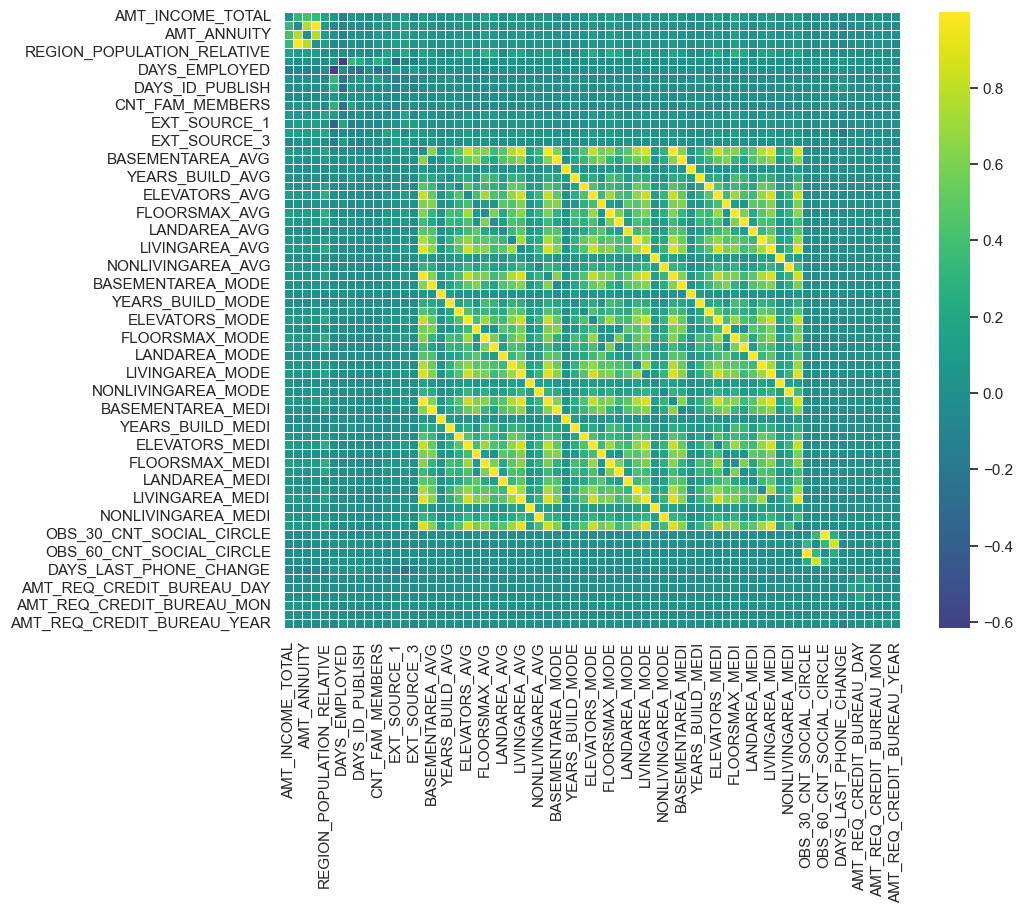

0

In [37]:
list_var_continuous = list(pd_loan_train.select_dtypes('float').columns)

funciones.get_corr_matrix(dataset = pd_loan_train[list_var_continuous], 
                metodo='pearson', size_figure=[10,8])

Dado que se han imputado los valores faltantes utilizando la mediana, al revisar la matriz de correlación de Pearson no se han observado diferencias significativas en comparación con los datos originales. Esto significa que el método de imputación ha funcionado bien y no ha alterado las relaciones entre las variables en el conjunto de datos.

# Tratamiento de las variables categoricas:


El tratamiento de las variables categóricas incluye evaluar su relación y relevancia para el modelo. La medida V-Cramér evalúa la fuerza de la asociación entre dos variables categóricas, con valores cercanos a 1 indicando una fuerte relación. Este análisis ayuda a seleccionar variables relevantes y eliminar redundancias.

In [39]:
confusion_matrix = pd.crosstab(pd_loan_train["TARGET"], pd_loan_train["TARGET"])
funciones.cramers_v(confusion_matrix.values)

0.9999726127135284

Analizamos la medida V de Cramér para cada una de las variables categóricas.

In [40]:
list_var_cat = [var for var in list_var_cat if var != "TARGET"]

# Iterar sobre las variables categóricas
# ==============================================================================
for var in list_var_cat:
    print(f"Variable: {var}")
    
    # Matriz de confusión
    confusion_matrix = pd.crosstab(pd_loan_train["TARGET"], pd_loan_train[var])
    print("Confusion Matrix:")
    print(confusion_matrix)
    
    # Calcular Cramér's V
    cramer_v_value = funciones.cramers_v(confusion_matrix.values)
    print(f"Cramér's V: {cramer_v_value}")
    print("-" * 50)

Variable: NAME_CONTRACT_TYPE
Confusion Matrix:
NAME_CONTRACT_TYPE  Cash loans  Revolving loans
TARGET                                         
0                       204019            22129
1                        18574             1286
Cramér's V: 0.03063340425944581
--------------------------------------------------
Variable: CODE_GENDER
Confusion Matrix:
CODE_GENDER       F      M  XNA
TARGET                         
0            150575  75569    4
1             11357   8503    0
Cramér's V: 0.05391925627367946
--------------------------------------------------
Variable: FLAG_OWN_CAR
Confusion Matrix:
FLAG_OWN_CAR       N      Y
TARGET                     
0             148567  77581
1              13809   6051
Cramér's V: 0.021959051333866695
--------------------------------------------------
Variable: FLAG_OWN_REALTY
Confusion Matrix:
FLAG_OWN_REALTY      N       Y
TARGET                        
0                69161  156987
1                 6294   13566
Cramér's V: 0.00622069

Confusion Matrix:
REGION_RATING_CLIENT_W_CITY      1       2      3
TARGET                                           
0                            25982  169037  31129
1                             1360   14485   4015
Cramér's V: 0.06020767001429367
--------------------------------------------------
Variable: WEEKDAY_APPR_PROCESS_START
Confusion Matrix:
WEEKDAY_APPR_PROCESS_START  FRIDAY  MONDAY  SATURDAY  SUNDAY  THURSDAY  \
TARGET                                                                   
0                            36996   37321     24923   11869     37249   
1                             3263    3197      2135    1029      3265   

WEEKDAY_APPR_PROCESS_START  TUESDAY  WEDNESDAY  
TARGET                                          
0                             39682      38108  
1                              3567       3404  
Cramér's V: 0.0
--------------------------------------------------
Variable: REG_REGION_NOT_LIVE_REGION
Confusion Matrix:
REG_REGION_NOT_LIVE_REGION   

Confusion Matrix:
WALLSMATERIAL_MODE  Block  Mixed  Monolithic  Others  Panel  Stone, brick  \
TARGET                                                                      
0                    6848   1667        1356    1183  49649         47962   
1                     508    147          68     110   3384          3831   

WALLSMATERIAL_MODE  Wooden  
TARGET                      
0                     3891  
1                      419  
Cramér's V: 0.029548956479788134
--------------------------------------------------
Variable: EMERGENCYSTATE_MODE
Confusion Matrix:
EMERGENCYSTATE_MODE      No   Yes
TARGET                           
0                    118735  1689
1                      8885   184
Cramér's V: 0.012967084263474872
--------------------------------------------------
Variable: FLAG_DOCUMENT_2
Confusion Matrix:
FLAG_DOCUMENT_2       0  1
TARGET                    
0                226139  9
1                 19856  4
Cramér's V: 0.004608500646534983
--------------------

Las variables analizadas muestran asociaciones débiles con la variable objetivo (`TARGET`), según los valores de Cramér's V, la mayoría menores a 0.1, indicando baja relación entre ellas y el incumplimiento de pagos. Esto sugiere que otras variables o enfoques podrían ser necesarios para mejorar el modelo predictivo.

Adicionalmente al coeficiente V de Cramer, he analizado en las variables categóricas el Weight of Evidence (WOE) y el Information Value (IV). El WOE mide la fuerza de la relación entre una variable categórica y la variable objetivo, transformando las categorías en valores continuos que reflejan el riesgo de un evento. Por su parte, el IV cuantifica la capacidad predictiva de una variable categórica, indicando qué tan bien una variable distingue entre las clases del objetivo.

In [44]:
# Iterar sobre las variables categóricas
# ==============================================================================
for var in list_var_cat:
    print(f"Variable: {var}")
    # Calcular WOE
    woe_value = funciones.calculate_woe(pd_loan_train, 'TARGET', var)
    print(f"IV: {woe_value}")
    print("-" * 50)

Variable: NAME_CONTRACT_TYPE
IV: TARGET                   WOE
NAME_CONTRACT_TYPE          
Cash loans         -0.036032
Revolving loans     0.412870
--------------------------------------------------
Variable: CODE_GENDER
IV: TARGET            WOE
CODE_GENDER          
F            0.152145
M           -0.247855
XNA               inf
--------------------------------------------------
Variable: FLAG_OWN_CAR
IV: TARGET             WOE
FLAG_OWN_CAR          
N            -0.056767
Y             0.118617
--------------------------------------------------
Variable: FLAG_OWN_REALTY
IV: TARGET                WOE
FLAG_OWN_REALTY          
N               -0.035642
Y                0.016114
--------------------------------------------------
Variable: CNT_CHILDREN
IV: TARGET             WOE
CNT_CHILDREN          
0             0.052393
1            -0.114415
2            -0.087618
3            -0.221418
4            -0.576835
5             0.308358
6            -1.644025
7                  inf
8

IV: TARGET                   WOE
WALLSMATERIAL_MODE          
Block               0.013956
Mixed              -0.158926
Monolithic          0.405512
Others             -0.211946
Panel               0.098645
Stone, brick       -0.059991
Wooden             -0.358724
--------------------------------------------------
Variable: EMERGENCYSTATE_MODE
IV: TARGET                    WOE
EMERGENCYSTATE_MODE          
No                   0.006373
Yes                 -0.369201
--------------------------------------------------
Variable: FLAG_DOCUMENT_2
IV: TARGET                WOE
FLAG_DOCUMENT_2          
0                0.000162
1               -1.621552
--------------------------------------------------
Variable: FLAG_DOCUMENT_3
IV: TARGET                WOE
FLAG_DOCUMENT_3          
0                0.288993
1               -0.100225
--------------------------------------------------
Variable: FLAG_DOCUMENT_4
IV: TARGET                WOE
FLAG_DOCUMENT_4          
0               -0.000084
1

Teniendo en cuenta que la variable objetivo indica si el cliente ha tenido dificultades de pago (1) o no (0), los valores de WOE reflejan cómo las categorías de las variables afectan la probabilidad de que un cliente tenga problemas de pago.

Por ejemplo, en la variable de nivel educativo del cliente, el valor de WOE para los que tienen título académico (1.33) sugiere que estos clientes tienen una mayor probabilidad de no tener dificultades de pago. En cambio, los clientes con secundaria incompleta tienen un valor de WOE negativo (-0.30), lo que indica que tienen más probabilidades de experimentar dificultades de pago.

En cuanto al tipo de contrato, los préstamos revolventes tienen un WOE positivo (0.41), lo que sugiere que los clientes con este tipo de préstamo tienen menos probabilidades de tener problemas de pago. Por otro lado, los préstamos en efectivo tienen un WOE cercano a cero, lo que implica que hay una relación débil con la probabilidad de impago.

Como mencionamos antes, la variable de tipo de ingreso es clave. Los empresarios y estudiantes tienen un WOE infinito, lo que indica que tienen una relación muy fuerte con un bajo riesgo de impago. En cambio, los desempleados tienen un WOE negativo (-1.81), lo que refleja un alto riesgo de dificultades de pago.

También es relevante el WOE de la cantidad de hijos. A medida que el número de hijos aumenta, el WOE disminuye, lo que sugiere que los clientes con más hijos tienen una mayor probabilidad de enfrentar dificultades de pago.

Por último, en cuanto al tipo de ocupación, las ocupaciones de contables y gerentes tienen valores de WOE positivos, lo que indica un menor riesgo de impago, mientras que los trabajadores no calificados tienen un WOE negativo significativo (-0.78), lo que sugiere una mayor probabilidad de dificultades de pago.

In [46]:
# Iterar sobre las variables categóricas
for var in list_var_cat:
    print(f"Variable: {var}")
    # Calcular IV
    iv_value = funciones.calculate_iv(pd_loan_train, 'TARGET', var)
    print(f"IV: {iv_value}")
    print("-" * 50)

Variable: NAME_CONTRACT_TYPE
IV: 0.014858015991943418
--------------------------------------------------
Variable: CODE_GENDER
IV: inf
--------------------------------------------------
Variable: FLAG_OWN_CAR
IV: 0.006729698450707212
--------------------------------------------------
Variable: FLAG_OWN_REALTY
IV: 0.0005743146545654015
--------------------------------------------------
Variable: CNT_CHILDREN
IV: inf
--------------------------------------------------
Variable: NAME_TYPE_SUITE
IV: 0.0016197070389929794
--------------------------------------------------
Variable: NAME_INCOME_TYPE
IV: inf
--------------------------------------------------
Variable: NAME_EDUCATION_TYPE
IV: 0.050688378574963514
--------------------------------------------------
Variable: NAME_FAMILY_STATUS
IV: inf
--------------------------------------------------
Variable: NAME_HOUSING_TYPE
IV: 0.015966243440681843
--------------------------------------------------
Variable: FLAG_MOBIL
IV: inf
--------------

En resumen, las variables con un IV alto, como `OCCUPATION_TYPE` y `NAME_EDUCATION_TYPE`, tienen un mayor poder predictivo y son útiles para predecir las dificultades de pago. Por otro lado, las variables con un IV bajo o cercano a cero, como `FLAG_MOBIL` y `FLAG_CONT_MOBILE`, no aportan mucha información y podrían no ser relevantes para el modelo. En general, las variables con un IV más alto son las más importantes para el modelo, mientras que aquellas con IV bajo o infinito son candidatas a ser revisadas para evaluar su utilidad.

## Tratamiento de valores nulos:

En las variables categóricas, los valores nulos suelen reemplazarse asignando una nueva categoría: "Sin valor". 

In [47]:
pd_loan_train[list_var_cat] = pd_loan_train[list_var_cat].astype("object").fillna("SIN VALOR").astype("category")
pd_loan_test[list_var_cat] = pd_loan_test[list_var_cat].astype("object").fillna("SIN VALOR").astype("category")

Es importante recordar que los datos de tipo entero definidos como categóricos, incluidas las variables booleanas, no presentan valores nulos. Sin embargo, si los tuvieran, deberían haberse tratado como parte del manejo de valores nulos numéricos. Para las variables booleanas, una opción sería imputar los nulos con -1, mientras que para las demás variables categóricas numéricas, sería necesario analizarlas con más detalle. Siguiendo el enfoque empleado hasta ahora, podríamos imputar los nulos con la mediana.

# Guardado de los datos:

Guardamos el DataFrame para conservar este nuevo estado intermedio y facilitar su uso en futuras etapas del análisis.

In [48]:
# Datos de entrenamiento
# ==============================================================================
pd_loan_train.to_csv("../data/interim/train_pd_data_preprocessing_missing_outlier.csv")

# Datos de test
# ==============================================================================
pd_loan_test.to_csv("../data/interim/test_pd_data_preprocessing_missing_outlier.csv")

In [49]:
print(pd_loan_train.shape, pd_loan_test.shape)

(246008, 121) (61503, 121)
